This notebook is focused on using reinforcement learning to train an agent that can efficiently manage network resources, particularly Baseband Units (BBUs), in a telecommunications network. The BBUEnvironment simulates real-world conditions by providing state information (such as energy consumption and latency) and rewarding or penalizing the agent based on its decisions. The agent is trained using a DQN model to optimize throughput and latency while minimizing energy consumption, and its performance is evaluated over multiple training episodes.

# **Step 1: Install Libraries**

In [1]:
pip install pandas numpy scikit-learn tabulate torch seaborn tensorflow 


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Colab

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
import gc

# Call garbage collection after certain episodes to clear unused memory
gc.collect()

475

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!nvidia-smi

2024-11-05 18:35:33.400540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 18:35:33.570144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 18:35:33.620361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 18:35:33.958121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-05 18:35:35.794045: W tensorflow/compiler/tf2

Num GPUs Available:  3
Tue Nov  5 18:35:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100S-PCIE-32GB          On  | 00000000:25:00.0 Off |                    0 |
| N/A   67C    P0             248W / 250W |  31130MiB / 32768MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

# **Step 2: Import Libraries and Load the Dataset**
In the next cell, import the required libraries and load the dataset:


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import os
import logging
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate



# Load the dataset
#file_path = '/home/xkolac15/pesbiu2.0/data/combined_granular_all_sites.csv'
file_path = '/home/xkolac15/pesbiu2.0/data/combined_granular_all_sites_predicted_incl.csv'
#file_path = '/home/xkolac15/pesbiu2.0/data/combined_granular_all_sites_evalshift.csv'
df = pd.read_csv(file_path)

# Ensure 'Datetime' is in datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort the dataset by datetime
df = df.sort_values('Datetime')

# Display the first few rows to understand the dataframe
print("First few rows of the dataset:")
print(df.head())


2024-11-10 19:27:15.913077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 19:27:15.931143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 19:27:15.936586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 19:27:15.949779: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-10 19:27:17.020205: W tensorflow/compiler/tf2

First few rows of the dataset:
             Datetime Time interval [hh:mm] Day of Week  Month  \
0 2024-06-09 00:00:00               0:00:00      Sunday      6   
1 2024-06-09 00:15:00               0:15:00      Sunday      6   
2 2024-06-09 00:30:00               0:30:00      Sunday      6   
3 2024-06-09 00:45:00               0:45:00      Sunday      6   
4 2024-06-09 01:00:00               1:00:00      Sunday      6   

   B1 Total port Tput [Mbps]  B1 UE DlLatency [ms]  \
0                     14.718                   4.5   
1                      9.095                   6.8   
2                      8.958                   6.6   
3                     11.873                   5.3   
4                     10.183                   5.9   

   B1 BBU1 AVG Power consumption [W]  B2 Total port Tput [Mbps]  \
0                              137.8                     28.077   
1                              137.8                     26.430   
2                              137.6          

# **Step 3: Preprocess the Dataset**
This part of the code performs a **linear regression analysis** to model the relationship between **throughput**, **energy consumption**, and **latency** for three different Baseband Units (BBUs)for three cell sites. The goal is to calculate coefficients that describe how energy consumption and latency change as throughput increases.

This section of code focuses on data preprocessing. It extracts relevant columns from the dataset, handles datetime and categorical features, and then normalizes the data for further machine learning tasks.

In [2]:
# Function to calculate coefficients for a given BBU
def calculate_coefficients(throughput, energy, latency):
    """
    Calculate the coefficients for energy and latency models using linear regression.

    Parameters:
    - throughput: Array of throughput values.
    - energy: Array of energy consumption values.
    - latency: Array of latency values.

    Returns:
    - k_B: Coefficient for energy model.
    - E_base_B: Intercept for energy model.
    - m_B: Coefficient for latency model.
    - L_base_B: Intercept for latency model.
    """
    energy_reg = LinearRegression().fit(throughput, energy)
    k_B = energy_reg.coef_[0][0]
    E_base_B = energy_reg.intercept_[0]

    latency_reg = LinearRegression().fit(throughput, latency)
    m_B = latency_reg.coef_[0][0]
    L_base_B = latency_reg.intercept_[0]

    return k_B, E_base_B, m_B, L_base_B

In [3]:
def preprocess_states(df, cell_sites):
    """
    Preprocess the dataset to extract and format the necessary columns.

    Parameters:
    - df: Original DataFrame containing the dataset.
    - cell_sites: List of cell site identifiers.

    Returns:
    - states: Preprocessed DataFrame with selected and formatted columns.
    """
    # Initialize the list of selected columns
    selected_columns = ['Datetime', 'Time interval [hh:mm]', 'Day of Week', 'Month']
    for site in cell_sites:
        for bbu in range(1, 4):
            selected_columns += [
                f'{site}{bbu} Total port Tput [Mbps]',
                f'{site}{bbu} UE DlLatency [ms]',
                f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
            ]
    states = df[selected_columns].copy()

    # Parse 'Time interval [hh:mm]' to datetime
    states['Time interval [hh:mm]'] = pd.to_datetime(states['Time interval [hh:mm]'], format='%H:%M:%S')

    # Extract 'Hour' and 'Minute'
    states['Hour'] = states['Time interval [hh:mm]'].dt.hour
    states['Minute'] = states['Time interval [hh:mm]'].dt.minute

    # Create 'Hour_decimal'
    states['Hour_decimal'] = states['Hour'] + states['Minute'] / 60

    # Map 'Day of Week' to numerical values
    day_mapping = {'Monday': 0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
    states['Day'] = states['Day of Week'].map(day_mapping)

    # Drop unnecessary columns
    states = states.drop(['Time interval [hh:mm]', 'Day of Week', 'Hour', 'Minute'], axis=1)

    # Rearrange columns
    ordered_columns = ['Datetime', 'Hour_decimal', 'Day', 'Month']
    for site in cell_sites:
        for bbu in range(1, 4):
            ordered_columns += [
                f'{site}{bbu} Total port Tput [Mbps]',
                f'{site}{bbu} UE DlLatency [ms]',
                f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
            ]
    states = states[ordered_columns]

    return states

# Define cell sites
cell_sites = ['B', 'D', 'G']

# Preprocess the data
states = preprocess_states(df, cell_sites)

# Print the date range in the data
print("Date range in the data:", states['Datetime'].min(), "to", states['Datetime'].max())

# Initialize separate scalers for each cell site
scalers = {}
for site in cell_sites:
    # Define the columns relevant to the site
    site_columns = ['Hour_decimal', 'Day', 'Month']
    for bbu in range(1, 4):
        site_columns += [
            f'{site}{bbu} Total port Tput [Mbps]',
            f'{site}{bbu} UE DlLatency [ms]',
            f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
        ]
    # Extract data for the site
    site_data = states[site_columns]
    # Fit the scaler
    scaler = StandardScaler()
    scaler.fit(site_data)
    scalers[site] = scaler
    print(f"Scaler fitted for cell site {site}.")

print("\nPreprocessed states (first 5 rows):")
print(states.head())

Date range in the data: 2024-06-09 00:00:00 to 2024-06-23 02:15:00
Scaler fitted for cell site B.
Scaler fitted for cell site D.
Scaler fitted for cell site G.

Preprocessed states (first 5 rows):
             Datetime  Hour_decimal  Day  Month  B1 Total port Tput [Mbps]  \
0 2024-06-09 00:00:00          0.00    6      6                     14.718   
1 2024-06-09 00:15:00          0.25    6      6                      9.095   
2 2024-06-09 00:30:00          0.50    6      6                      8.958   
3 2024-06-09 00:45:00          0.75    6      6                     11.873   
4 2024-06-09 01:00:00          1.00    6      6                     10.183   

   B1 UE DlLatency [ms]  B1 BBU1 AVG Power consumption [W]  \
0                   4.5                              137.8   
1                   6.8                              137.8   
2                   6.6                              137.6   
3                   5.3                              137.4   
4                   5.9 

In [4]:
def preprocess_states(df, cell_sites):
    """
    Preprocess the dataset to extract and format the necessary columns.

    Parameters:
    - df: Original DataFrame containing the dataset.
    - cell_sites: List of cell site identifiers.

    Returns:
    - states: Preprocessed DataFrame with selected and formatted columns.
    """
    # Initialize the list of selected columns
    selected_columns = ['Datetime', 'Time interval [hh:mm]', 'Day of Week', 'Month']
    for site in cell_sites:
        for bbu in range(1, 4):
            selected_columns += [
                f'{site}{bbu} Total port Tput [Mbps]',
                f'{site}{bbu} UE DlLatency [ms]',
                f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
            ]
    states = df[selected_columns].copy()

    # Parse 'Time interval [hh:mm]' to datetime
    states['Time interval [hh:mm]'] = pd.to_datetime(states['Time interval [hh:mm]'], format='%H:%M:%S')

    # Extract 'Hour' and 'Minute'
    states['Hour'] = states['Time interval [hh:mm]'].dt.hour
    states['Minute'] = states['Time interval [hh:mm]'].dt.minute

    # Create 'Hour_decimal'
    states['Hour_decimal'] = states['Hour'] + states['Minute'] / 60

    # Map 'Day of Week' to numerical values
    day_mapping = {'Monday': 0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
    states['Day'] = states['Day of Week'].map(day_mapping)

    # Drop unnecessary columns
    states = states.drop(['Time interval [hh:mm]', 'Day of Week', 'Hour', 'Minute'], axis=1)

    # Rearrange columns
    ordered_columns = ['Datetime', 'Hour_decimal', 'Day', 'Month']
    for site in cell_sites:
        for bbu in range(1, 4):
            ordered_columns += [
                f'{site}{bbu} Total port Tput [Mbps]',
                f'{site}{bbu} UE DlLatency [ms]',
                f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
            ]
    states = states[ordered_columns]

    return states

# Define cell sites
cell_sites = ['B', 'D', 'G']

# Preprocess the data
states = preprocess_states(df, cell_sites)

# Print the date range in the data
print("Date range in the data:", states['Datetime'].min(), "to", states['Datetime'].max())

# Initialize separate scalers for each cell site
scalers = {}
for site in cell_sites:
    # Define the columns relevant to the site
    site_columns = ['Hour_decimal', 'Day', 'Month']
    for bbu in range(1, 4):
        site_columns += [
            f'{site}{bbu} Total port Tput [Mbps]',
            f'{site}{bbu} UE DlLatency [ms]',
            f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
        ]
    # Extract data for the site
    site_data = states[site_columns]
    # Fit the scaler
    scaler = StandardScaler()
    scaler.fit(site_data)
    scalers[site] = scaler
    print(f"Scaler fitted for cell site {site}.")

print("\nPreprocessed states (first 5 rows):")
print(states.head())

Date range in the data: 2024-06-09 00:00:00 to 2024-06-23 02:15:00
Scaler fitted for cell site B.
Scaler fitted for cell site D.
Scaler fitted for cell site G.

Preprocessed states (first 5 rows):
             Datetime  Hour_decimal  Day  Month  B1 Total port Tput [Mbps]  \
0 2024-06-09 00:00:00          0.00    6      6                     14.718   
1 2024-06-09 00:15:00          0.25    6      6                      9.095   
2 2024-06-09 00:30:00          0.50    6      6                      8.958   
3 2024-06-09 00:45:00          0.75    6      6                     11.873   
4 2024-06-09 01:00:00          1.00    6      6                     10.183   

   B1 UE DlLatency [ms]  B1 BBU1 AVG Power consumption [W]  \
0                   4.5                              137.8   
1                   6.8                              137.8   
2                   6.6                              137.6   
3                   5.3                              137.4   
4                   5.9 

In [5]:
# Function to calculate coefficients for all BBUs across all cell sites
def calculate_all_coefficients(df, cell_sites):
    """
    Calculate coefficients and maximum throughputs for all BBUs across all cell sites.

    Parameters:
    - df: Original DataFrame containing the dataset.
    - cell_sites: List of cell site identifiers.

    Returns:
    - coefficients: Dictionary containing coefficients for each BBU.
    - max_throughputs: Dictionary containing maximum throughput for each BBU.
    """
    coefficients = {}
    max_throughputs = {}
    for site in cell_sites:
        for bbu in range(1, 4):
            throughput = df[[f'{site}{bbu} Total port Tput [Mbps]']].values
            energy = df[[f'{site}{bbu} BBU{bbu} AVG Power consumption [W]']].values
            latency = df[[f'{site}{bbu} UE DlLatency [ms]']].values

            k, E_base, m, L_base = calculate_coefficients(throughput, energy, latency)
            coefficients[f'{site}{bbu}'] = {'k': k, 'E_base': E_base, 'm': m, 'L_base': L_base}

            max_throughput = df[f'{site}{bbu} Total port Tput [Mbps]'].max()
            max_throughputs[f'{site}{bbu}'] = max_throughput
            print(f"{site}{bbu}: k={k}, E_base={E_base}, m={m}, L_base={L_base}, Max Throughput={max_throughput} Mbps")
    return coefficients, max_throughputs

# Preprocess the data
states = preprocess_states(df, cell_sites)

# Calculate coefficients and max throughput for all BBUs
coefficients, max_throughputs = calculate_all_coefficients(df, cell_sites)


B1: k=0.1106017685257535, E_base=136.28959023329617, m=0.06651292315148054, L_base=6.271170454209134, Max Throughput=49.489 Mbps
B2: k=0.09275544029873362, E_base=113.40506925464769, m=0.09065553575703027, L_base=5.360850107500669, Max Throughput=62.866 Mbps
B3: k=0.13261676651690776, E_base=117.3871116716952, m=0.03625717542643983, L_base=6.659040792559112, Max Throughput=51.309 Mbps
D1: k=0.047895643887443586, E_base=135.82009123972068, m=0.0528644928736454, L_base=5.370403367034799, Max Throughput=76.253 Mbps
D2: k=0.03889117118977245, E_base=131.8896300691865, m=-0.0008142086022147432, L_base=7.863925758903384, Max Throughput=93.469 Mbps
D3: k=0.028217357502560707, E_base=111.58186321893143, m=0.020099640179217, L_base=6.810974850787306, Max Throughput=85.647 Mbps
G1: k=0.10705005354276541, E_base=138.43477778401677, m=0.04361081344738558, L_base=6.527142977712773, Max Throughput=62.921 Mbps
G2: k=0.04983096594500049, E_base=130.7090461143764, m=0.019891561815818817, L_base=5.92641

# **Step 4: BBU Enviroment Set Up**
This class simulates a reinforcement learning environment for optimizing the energy consumption of Baseband Units (BBUs) in a cellular network. The environment models traffic, energy, and latency at different time steps, allowing for dynamic decision-making based on current network conditions. Below is a detailed explanation of each component of the class.

In [6]:
class BBUEnvironment:
    def __init__(self, states, coefficients, max_throughputs, cell_sites,
                 threshold_latency=10, threshold_savings=100, max_utilization=0.8, coefficient=1.1):
        """
        Initialize the BBUEnvironment.

        Parameters:
        - states: Preprocessed states DataFrame.
        - coefficients: Dictionary of coefficients for each BBU.
        - max_throughputs: Dictionary of maximum throughputs for each BBU.
        - cell_sites: List of cell site identifiers.
        - threshold_latency: Threshold for latency penalty.
        - threshold_savings: Threshold for energy savings.
        - max_utilization: Maximum utilization factor for BBUs.
        - coefficient: Coefficient to adjust the maximum throughput.
        """
        self.states_df = states.reset_index(drop=True)
        # Convert states to numpy array and drop 'Datetime' column
        self.states = states.drop(columns=['Datetime']).to_numpy()
        # Store column names excluding 'Datetime'
        self.columns = states.drop(columns=['Datetime']).columns
        self.current_step = 0
        self.cell_sites = cell_sites
        self.coefficients = coefficients
        self.max_throughputs = max_throughputs
        self.threshold_latency = threshold_latency
        self.threshold_savings = threshold_savings
        self.max_utilization = max_utilization
        self.coefficient = coefficient

        # Initialize BBU status for all cell sites (1 active, 0 inactive)
        self.bbu_status = {site: np.array([1, 1, 1]) for site in cell_sites}

        # Calculate max capacity per BBU after applying utilization factor
        self.max_capacity_per_bbu = {
            bbu: self.max_throughputs[bbu] * self.max_utilization * self.coefficient
            for bbu in max_throughputs
        }

        # Define maximum allowable latency increase per step to prevent spikes
        self.MAX_LATENCY_INCREASE = 10  # Adjust based on system requirements

        # Define maximum allowable overload traffic
        self.MAX_OVERLOAD = 10  # Adjust based on system requirements

        # Configure logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def reset(self):
        """
        Reset the environment to the initial state.

        Returns:
        - state: The initial state of the environment.
        """
        self.current_step = 0
        # Reset BBU status to all active
        self.bbu_status = {site: np.array([1, 1, 1]) for site in self.cell_sites}
        state = self._get_state()
        return state.copy()

    def _get_state(self):
        """
        Retrieve the current state of the environment.

        Returns:
        - state: The current state as a numpy array.
        """
        state = self.states[self.current_step, :].copy()
        return state

    def calculate_rewards_for_sleeping(self, current_step, site):
        """
        Calculate rewards for sleeping each BBU in a given site.

        Parameters:
        - current_step: The current time step index.
        - site: The cell site identifier.

        Returns:
        - rewards: List of rewards for each BBU in the site.
        """
        rewards = []
        # Get indices for the BBUs of this site
        site_columns = []
        for bbu in range(1, 4):
            throughput_col = f'{site}{bbu} Total port Tput [Mbps]'
            latency_col = f'{site}{bbu} UE DlLatency [ms]'
            energy_col = f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
            site_columns.extend([throughput_col, latency_col, energy_col])
        # Get the indices of these columns in the state
        indices = [list(self.columns).index(col) for col in site_columns]

        # Extract the current throughput, latency, energy for the site
        current_throughput = self.states[current_step, indices[::3]]
        current_latency = self.states[current_step, indices[1::3]]
        current_energy = self.states[current_step, indices[2::3]]

        # For each BBU in the site
        for bbu in range(3):
            # Energy saved for this BBU
            energy_saved = current_energy[bbu]

            # Throughput handled by this BBU
            bbu_throughput = current_throughput[bbu]

            # Avoid division by zero when throughput is very low
            if bbu_throughput == 0:
                bbu_throughput = 1

            # Calculate energy efficiency (energy saved per unit of throughput)
            energy_efficiency = energy_saved / bbu_throughput

            # Calculate latency penalty
            redistributed_throughput = bbu_throughput / 2  # Example redistribution
            bbu_id = f'{site}{bbu+1}'
            m = self.coefficients[bbu_id]['m']
            L_base = self.coefficients[bbu_id]['L_base']
            increased_latency = L_base + m * redistributed_throughput

            latency_penalty = increased_latency - current_latency[bbu]

            # Final reward based on energy efficiency and latency penalty
            reward = energy_efficiency - latency_penalty

            rewards.append(reward)

        return rewards

    def redistribute_throughput_single_bbu(self, bbu_throughput, remaining_bbues, total_throughput, site):
        """
        Redistribute the throughput of a sleeping BBU to the remaining active BBUs.

        Parameters:
        - bbu_throughput: The throughput of the BBU to be slept.
        - remaining_bbues: List of indices of remaining active BBUs.
        - total_throughput: Array of total throughputs for the BBUs.
        - site: The cell site identifier.

        Returns:
        - total_throughput: Updated array of total throughputs after redistribution.
        - additional_throughput_per_bbu: Array of additional throughput added to each active BBU.
        - overload_traffic: Amount of traffic that could not be redistributed.
        """
        max_capacity_per_bbu = self.max_capacity_per_bbu
        additional_throughput_per_bbu = np.zeros(len(total_throughput))
        overload_traffic = 0
        # Calculate total available capacity in remaining BBUs
        total_available_capacity = sum(
            max_capacity_per_bbu[f'{site}{bbu+1}'] - total_throughput[bbu] for bbu in remaining_bbues
        )

        if total_available_capacity <= 0 or bbu_throughput > total_available_capacity:
            print(f"Site {site}: Insufficient capacity to redistribute throughput.")
            overload_traffic = bbu_throughput
            return total_throughput, additional_throughput_per_bbu, overload_traffic

        # Distribute throughput proportionally based on available capacity
        redistributed_traffic = 0
        for bbu in remaining_bbues:
            available_capacity = max_capacity_per_bbu[f'{site}{bbu+1}'] - total_throughput[bbu]
            proportion = available_capacity / total_available_capacity
            throughput_to_add = proportion * min(bbu_throughput, total_available_capacity)
            total_throughput[bbu] += throughput_to_add
            additional_throughput_per_bbu[bbu] += throughput_to_add
            redistributed_traffic += throughput_to_add

        # Calculate any remaining overload
        overload_traffic = bbu_throughput - redistributed_traffic
        overload_traffic = max(overload_traffic, 0)

        return total_throughput, additional_throughput_per_bbu, overload_traffic

    def step(self, action=None):
        """
        Perform a step in the environment.

        Parameters:
        - action: (Optional) The action to take. Not used since we're using adaptive logic.

        Returns:
        - next_state: The next state of the environment.
        - total_reward: The total reward obtained in this step.
        - done: Boolean indicating if the episode has ended.
        - energy_consumptions: Dictionary of energy consumptions for each site.
        - latencies: Dictionary of average latencies for each site.
        - throughputs: Dictionary of total throughputs for each site.
        - info: Dictionary containing detailed info for each site.
        """
        # Check if we've reached the end of the dataset
        done = self.current_step >= len(self.states) - 1
        if done:
            print("Episode finished.")
            return None, 0, done, None, None, None, None

        # Get the current state
        state = self.states[self.current_step, :].copy()

        total_reward = 0

        # Initialize dictionaries to collect metrics
        energy_consumptions = {}
        latencies = {}
        throughputs = {}
        info = {}

        # Loop over each cell site
        for site_idx, site in enumerate(self.cell_sites):
            # Get indices for the BBUs of this site
            site_columns = []
            for bbu in range(1, 4):
                throughput_col = f'{site}{bbu} Total port Tput [Mbps]'
                latency_col = f'{site}{bbu} UE DlLatency [ms]'
                energy_col = f'{site}{bbu} BBU{bbu} AVG Power consumption [W]'
                site_columns.extend([throughput_col, latency_col, energy_col])
            # Get the indices of these columns in the state
            indices = [list(self.columns).index(col) for col in site_columns]

            # Extract the current throughput, latency, energy for the site
            current_throughput = state[indices[::3]]
            current_latency = state[indices[1::3]]
            current_energy = state[indices[2::3]]

            # Calculate rewards for sleeping each BBU
            rewards = self.calculate_rewards_for_sleeping(self.current_step, site)

            # Rank BBUs based on rewards (descending order)
            bbues_ranked = np.argsort(rewards)[::-1]

            bbues_to_sleep = []
            active_bbues = [0, 1, 2]  # All BBUs start as active

            # Initialize total_throughput and additional_throughput_per_bbu
            total_throughput = current_throughput.copy()
            additional_throughput_per_bbu = np.zeros(len(total_throughput))
            overload_traffic = 0

            total_network_throughput = np.sum(current_throughput)
            if total_network_throughput == 0:
                print(f"Site {site}: Total throughput is zero; no BBUs will be put to sleep.")
                bbues_to_sleep = []
                active_bbues = [0, 1, 2]
            else:
                for bbu in bbues_ranked:
                    if bbu in active_bbues:
                        if len(active_bbues) <= 1:
                            print(f"Site {site}: Cannot sleep BBU {bbu}; at least one BBU must remain active.")
                            continue
                        bbu_throughput = total_throughput[bbu]
                        # Remaining BBUs excluding the current one
                        remaining_bbues = [i for i in active_bbues if i != bbu]
                        # Total available capacity in remaining BBUs
                        total_remaining_capacity = sum(
                            self.max_capacity_per_bbu[f'{site}{i+1}'] - total_throughput[i] for i in remaining_bbues
                        )

                        if total_remaining_capacity >= bbu_throughput:
                            # Other BBUs can handle the throughput
                            bbues_to_sleep.append(bbu)
                            active_bbues.remove(bbu)  # Remove the BBU to be slept from the active list
                            # Set the sleeping BBU's throughput to 0
                            total_throughput[bbu] = 0
                            # Redistribute the BBU's throughput among active BBUs
                            total_throughput, additional_throughput, overload = self.redistribute_throughput_single_bbu(
                                bbu_throughput, remaining_bbues, total_throughput, site
                            )
                            overload_traffic += overload
                            additional_throughput_per_bbu += additional_throughput
                        else:
                            print(f"Site {site}: Cannot sleep BBU {bbu}; not enough capacity in other BBUs.")
                            continue

                print(f"Site {site}: BBUs chosen to sleep: {bbues_to_sleep}")

            # Update the BBU status
            self.bbu_status[site] = np.array([1 if i in active_bbues else 0 for i in range(3)])

            # Recalculate energy, latency, throughput
            updated_throughput = total_throughput.copy()
            updated_latency = current_latency.copy()
            updated_energy = current_energy.copy()

            if bbues_to_sleep:
                # Only recalculate latency and energy if some BBUs are put to sleep
                for bbu in active_bbues:
                    # Get the additional throughput added to this BBU
                    additional_throughput = additional_throughput_per_bbu[bbu]
                    bbu_id = f'{site}{bbu+1}'
                    m = self.coefficients[bbu_id]['m']
                    k = self.coefficients[bbu_id]['k']
                    E_base = self.coefficients[bbu_id]['E_base']
                    # Increase latency by adding term proportional to additional throughput
                    latency_increase = m * additional_throughput
                    latency_increase = min(latency_increase, self.MAX_LATENCY_INCREASE)
                    updated_latency[bbu] += latency_increase
                    # Update energy based on new throughput
                    updated_energy[bbu] = E_base + k * updated_throughput[bbu]

                # Set energy, latency, and throughput to 0 for sleeping BBUs
                for bbu in bbues_to_sleep:
                    updated_energy[bbu] = 0
                    updated_latency[bbu] = 0
                    updated_throughput[bbu] = 0
            else:
                # No BBUs are put to sleep, so no changes
                updated_throughput = current_throughput.copy()
                updated_latency = current_latency.copy()
                updated_energy = current_energy.copy()

            # Update the state accordingly
            state[indices[::3]] = updated_throughput
            state[indices[1::3]] = updated_latency
            state[indices[2::3]] = updated_energy

            # Compute reward
            reward = self.compute_reward(site, current_energy, updated_energy,
                                         current_latency, updated_latency,
                                         current_throughput, updated_throughput,
                                         overload_penalty=overload_traffic)
            total_reward += reward

            # Collect metrics
            total_energy = np.sum(updated_energy)
            total_latency = np.sum(updated_latency * updated_throughput)
            total_throughput_site = np.sum(updated_throughput)
            average_latency = total_latency / (total_throughput_site if total_throughput_site > 0 else 1)

            energy_consumptions[site] = total_energy
            latencies[site] = average_latency
            throughputs[site] = total_throughput_site

            # Store info for debugging or detailed evaluation
            info[site] = {
                'reward': reward,
                'total_energy': total_energy,
                'average_latency': average_latency,
                'total_throughput': total_throughput_site,
                'current_energy': current_energy,
                'updated_energy': updated_energy,
                'current_latency': current_latency,
                'updated_latency': updated_latency,
                'current_throughput': current_throughput,
                'updated_throughput': updated_throughput,
                'BBU_status': self.bbu_status[site].copy(),
            }

        # Update the current step
        self.current_step += 1
        done = self.current_step >= len(self.states) - 1

        # Get the next state
        next_state = self._get_state()
        return next_state.copy(), total_reward, done, energy_consumptions, latencies, throughputs, info

    def compute_reward(self, site, current_energy, updated_energy, current_latency, updated_latency,
                       current_throughput, updated_throughput, overload_penalty=0):
        """
        Compute the reward for a specific site.

        Parameters:
        - site: The cell site identifier.
        - current_energy: Array of current energy consumption per BBU.
        - updated_energy: Array of updated energy consumption per BBU.
        - current_latency: Array of current latency per BBU.
        - updated_latency: Array of updated latency per BBU.
        - current_throughput: Array of current throughput per BBU.
        - updated_throughput: Array of updated throughput per BBU.
        - overload_penalty: Penalty for overload (default 0).

        Returns:
        - reward: The calculated reward for the site.
        """
        # Energy savings
        energy_savings = np.sum(current_energy) - np.sum(updated_energy)
        max_possible_energy_savings = np.sum(current_energy) if np.sum(current_energy) != 0 else 1
        normalized_energy_savings = energy_savings / max_possible_energy_savings

        # Total delay before and after the action
        current_total_delay = np.sum(current_throughput * current_latency)
        updated_total_delay = np.sum(updated_throughput * updated_latency)

        # Calculate latency increase
        latency_increase = updated_total_delay - current_total_delay
        max_delay = current_total_delay if current_total_delay != 0 else 1
        normalized_latency_penalty = latency_increase / max_delay

        # Normalize overload penalty
        normalized_overload_penalty = (overload_penalty / self.MAX_OVERLOAD) if self.MAX_OVERLOAD > 0 else 0
        normalized_overload_penalty = min(normalized_overload_penalty, 1.0)  # Cap at 1.0

        # Overload prevention bonus
        if overload_penalty == 0:
            number_of_active_bbues = np.sum(self.bbu_status[site])
            total_number_of_bbues = len(self.bbu_status[site])
            number_of_bbues_inactive = total_number_of_bbues - number_of_active_bbues

            delta = 0.12

            overload_prevention_bonus = delta * (1 + (number_of_bbues_inactive / total_number_of_bbues))
        else:
            overload_prevention_bonus = 0

        # Combine rewards and penalties
        alpha = 0.4  # Weight for energy savings
        beta = 0.2   # Weight for latency penalty
        gamma = 1.0  # Weight for overload penalty

        # Compute the reward
        reward = (alpha * normalized_energy_savings) - \
                 (beta * normalized_latency_penalty) - \
                 (gamma * normalized_overload_penalty) + \
                 overload_prevention_bonus

        # Optional: Logging for debugging
        if self.current_step % 100 == 0:  # Log every 100 steps
            self.logger.info(f"Site {site} - Energy Savings: {energy_savings:.2f}, Normalized: {normalized_energy_savings:.2f}")
            self.logger.info(f"Site {site} - Latency Increase: {latency_increase:.2f}, Normalized: {normalized_latency_penalty:.2f}")
            self.logger.info(f"Site {site} - Overload Penalty: {overload_penalty:.2f}, Normalized: {normalized_overload_penalty:.2f}")
            self.logger.info(f"Site {site} - Overload Prevention Bonus: {overload_prevention_bonus:.2f}")
            self.logger.info(f"Site {site} - Total Reward: {reward:.2f}")

        return reward


# **Step 5: Simulate the Environment**

In [7]:
def simulate_environment(env):
    """
    Simulate the environment over the entire dataset and collect metrics.

    Parameters:
    - env: The BBUEnvironment instance.

    Returns:
    - rewards_history: Dictionary of rewards over time for each site.
    - energy_history: Dictionary of energy consumption over time for each site.
    - latency_history: Dictionary of average latency over time for each site.
    - throughput_history: Dictionary of total throughput over time for each site.
    - actions_log: Dictionary of BBU statuses over time for each site.
    - bbu_sleep_counts: Dictionary of total sleep counts for each BBU in each site.
    """
    # Initialize logs
    rewards_history = {site: [] for site in env.cell_sites}
    energy_history = {site: [] for site in env.cell_sites}
    latency_history = {site: [] for site in env.cell_sites}
    throughput_history = {site: [] for site in env.cell_sites}
    actions_log = {site: [] for site in env.cell_sites}
    bbu_sleep_counts = {site: [0, 0, 0] for site in env.cell_sites}
    steps = 0

    # Reset the environment
    state = env.reset()
    done = False

    while not done:
        # Perform a step in the environment
        next_state, total_reward, done, energy_consumptions, latencies, throughputs, info = env.step()

        # Collect metrics
        for site in env.cell_sites:
            # Collect total reward per site
            rewards_history[site].append(info[site]['reward'])

            # Collect energy consumptions
            energy_history[site].append(info[site]['total_energy'])

            # Collect latency
            latency_history[site].append(info[site]['average_latency'])

            # Collect throughput
            throughput_history[site].append(info[site]['total_throughput'])

            # Collect BBU statuses
            bbu_status = env.bbu_status[site]
            actions_log[site].append(bbu_status.copy())

            # Count BBUs slept
            for idx, status in enumerate(bbu_status):
                if status == 0:
                    bbu_sleep_counts[site][idx] += 1

        state = next_state
        steps += 1

    return (rewards_history, energy_history, latency_history, throughput_history,
            actions_log, bbu_sleep_counts)
			

# **Step 6: Plotting Setup**


In [8]:
def plot_metric(history, metric_name, cell_sites):
    """
    Plot a metric over time for each cell site.

    Parameters:
    - history: Dictionary containing metric values over time for each site.
    - metric_name: Name of the metric to display on the plot.
    - cell_sites: List of cell site identifiers.
    """
    plt.rcParams.update({'font.size': 14})  # Set global font size to 14
    plt.figure(figsize=(12, 6))
    for site in cell_sites:
        plt.plot(history[site], label=f'{site}')
    plt.xlabel('Time Steps')  # Now uses the globally set font size
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()


In [9]:
def detailed_evaluation(env, day_of_week):
    """
    Perform detailed evaluation on a specific day of the week, collecting metrics
    before and after the environment's action, and visualize BBUs put to sleep.

    Parameters:
    - env: The BBUEnvironment instance.
    - day_of_week: Integer from 0 to 6 (0=Monday, 6=Sunday).
    """
    # Filter data for the specific day
    day_mask = env.states_df['Day'] == day_of_week
    indices = env.states_df[day_mask].index.tolist()

    if not indices:
        print(f"No data available for the day {day_of_week}")
        return

    # Initialize data structures to store metrics
    metrics_data = {site: [] for site in env.cell_sites}

    for idx in indices:
        # Set the current step to the specific index
        env.current_step = idx
        state = env._get_state()
        # Since actions are determined by the environment, we just step once
        _, _, _, _, _, _, info = env.step()

        for site in env.cell_sites:
            hour_decimal = env.states_df.iloc[idx]['Hour_decimal']
            hour = int(hour_decimal)
            minute = int((hour_decimal - hour) * 60)
            time_str = f"{hour:02d}:{minute:02d}"

            bbu_status = info[site]['BBU_status']
            bbues_sleep = [1 - s for s in bbu_status]

            metrics = {
                'Hour_decimal': hour_decimal,
                'Time': time_str,
                'BBUs_Sleep': bbues_sleep,  # 1 if BBU is put to sleep
                'Energy_Before': np.sum(info[site]['current_energy']),
                'Energy_After': np.sum(info[site]['updated_energy']),
                'Energy_Saving': np.sum(info[site]['current_energy']) - np.sum(info[site]['updated_energy']),
                'Latency_Before': np.sum(info[site]['current_latency'] * info[site]['current_throughput']) / (np.sum(info[site]['current_throughput']) + 1e-9),
                'Latency_After': np.sum(info[site]['updated_latency'] * info[site]['updated_throughput']) / (np.sum(info[site]['updated_throughput']) + 1e-9),
                'Throughput_Before': np.sum(info[site]['current_throughput']),
                'Throughput_After': np.sum(info[site]['updated_throughput']),
            }
            metrics_data[site].append(metrics)

    # Convert to DataFrame and visualize
    for site in env.cell_sites:
        df_metrics = pd.DataFrame(metrics_data[site])
        df_metrics.sort_values('Hour_decimal', inplace=True)

        # Visualization of BBUs put to sleep using stacked bars
        bbu_sleep_df = pd.DataFrame(df_metrics['BBUs_Sleep'].tolist(), columns=[f'BBU{i+1}_Sleep' for i in range(3)])
        bbu_sleep_df['Time'] = df_metrics['Time']

        # Set Time as categorical for proper ordering
        bbu_sleep_df['Time'] = pd.Categorical(bbu_sleep_df['Time'], ordered=True)

        # Plot stacked bar chart
        plt.figure(figsize=(18, 6))
        bbu_sleep_df.set_index('Time').plot(kind='bar', stacked=True, ax=plt.gca(),
                                            color=['#FF9999','#66B3FF','#99FF99'])
        plt.rcParams.update({'font.size': 18})  # Set global font size to 14
        plt.xlabel('Time (15-Minute Intervals)')
        plt.ylabel('BBU Sleep Status')
        plt.title(f'BBUs Put to Sleep on Day {day_of_week} for Site {site}')
        plt.legend(title='BBU', labels=[f'BBU1 Sleep', f'BBU2 Sleep', f'BBU3 Sleep'])
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
        

        # Energy Consumption Visualization
        plt.figure(figsize=(18, 6))
        plt.plot(df_metrics['Time'], df_metrics['Energy_Before'], label='Energy Before Action')
        plt.plot(df_metrics['Time'], df_metrics['Energy_After'], label='Energy After Action')
        plt.fill_between(df_metrics['Time'], df_metrics['Energy_Before'], df_metrics['Energy_After'], 
                         where=df_metrics['Energy_After'] < df_metrics['Energy_Before'], 
                         interpolate=True, color='green', alpha=0.3, label='Energy Savings')
        plt.xlabel('Time (15-Minute Intervals)')
        plt.ylabel('Energy Consumption (W)')
        plt.title(f'Energy Consumption Before and After Action on Day {day_of_week} for Site {site}')
        plt.legend()
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Latency Visualization
        plt.figure(figsize=(18, 6))
        plt.plot(df_metrics['Time'], df_metrics['Latency_Before'], label='Latency Before Action')
        plt.plot(df_metrics['Time'], df_metrics['Latency_After'], label='Latency After Action')
        plt.xlabel('Time (15-Minute Intervals)')
        plt.ylabel('Average Latency (ms)')
        plt.title(f'Latency Before and After Action on Day {day_of_week} for Site {site}')
        plt.legend()
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Throughput Visualization
        plt.figure(figsize=(18, 6))
        plt.plot(df_metrics['Time'], df_metrics['Throughput_Before'], label='Throughput Before Action')
        plt.plot(df_metrics['Time'], df_metrics['Throughput_After'], label='Throughput After Action')
        plt.xlabel('Time (15-Minute Intervals)')
        plt.ylabel('Total Throughput (Mbps)')
        plt.title(f'Throughput Before and After Action on Day {day_of_week} for Site {site}')
        plt.legend()
        plt.xticks(rotation=90)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Print metrics
        print(f"\nDetailed Metrics for Site {site} on Day {day_of_week}:")
        print(df_metrics[['Time', 'Energy_Before', 'Energy_After', 'Energy_Saving', 
                          'Latency_Before', 'Latency_After', 'Throughput_Before', 'Throughput_After']])

In [10]:
def detailed_evaluation_summary2(env, day_of_week):
    """
    Perform detailed evaluation on a specific day of the week and visualize BBUs put to sleep
    along with Energy, Latency, and Throughput using bar charts in a summary figure.

    Parameters:
    - env: The BBUEnvironment instance.
    - day_of_week: Integer from 0 to 6 (0=Monday, 6=Sunday).
    """
    # Filter data for the specific day
    day_mask = env.states_df['Day'] == day_of_week
    indices = env.states_df[day_mask].index.tolist()

    if not indices:
        print(f"No data available for the day {day_of_week}")
        return

    # Initialize data structures to store metrics
    metrics_data = {site: [] for site in env.cell_sites}

    for idx in indices:
        env.current_step = idx
        state = env._get_state()
        # Since actions are determined by the environment, we just step once
        _, _, _, _, _, _, info = env.step()

        for site in env.cell_sites:
            hour_decimal = env.states_df.iloc[idx]['Hour_decimal']
            hour = int(hour_decimal)
            minute = int((hour_decimal - hour) * 60)
            time_str = f"{hour:02d}:{minute:02d}"

            bbu_status = info[site]['BBU_status']
            bbues_sleep = [1 - s for s in bbu_status]

            metrics = {
                'Hour_decimal': hour_decimal,
                'Time': time_str,
                'BBUs_Sleep': bbues_sleep,  # 1 if BBU is put to sleep
                'Energy_Before': np.sum(info[site]['current_energy']),
                'Energy_After': np.sum(info[site]['updated_energy']),
                'Energy_Saving': np.sum(info[site]['current_energy']) - np.sum(info[site]['updated_energy']),
                'Latency_Before': np.sum(info[site]['current_latency'] * info[site]['current_throughput']) / (np.sum(info[site]['current_throughput']) + 1e-9),
                'Latency_After': np.sum(info[site]['updated_latency'] * info[site]['updated_throughput']) / (np.sum(info[site]['updated_throughput']) + 1e-9),
                'Throughput_Before': np.sum(info[site]['current_throughput']),
                'Throughput_After': np.sum(info[site]['updated_throughput']),
            }
            metrics_data[site].append(metrics)

    # Create a summary figure with subplots
    num_sites = len(env.cell_sites)
    num_metrics = 4  # BBUs Sleep, Energy, Latency, Throughput

    fig, axes = plt.subplots(num_sites, num_metrics, figsize=(20, 5 * num_sites))

    # Define colors for BBUs Sleep
    bbu_colors = ['#FF9999', '#66B3FF', '#99FF99']  # Colors for BBU1, BBU2, BBU3

    for i, site in enumerate(env.cell_sites):
        df = pd.DataFrame(metrics_data[site])
        df.sort_values('Hour_decimal', inplace=True)
        metrics_data[site] = df

        # 1. BBUs Put to Sleep (Stacked Bar Chart)
        ax = axes[i, 0]
        bbu_sleep = pd.DataFrame(df['BBUs_Sleep'].tolist(), columns=[f'BBU{i+1}_Sleep' for i in range(3)])
        bbu_sleep['Time'] = df['Time']
        bbu_sleep.set_index('Time', inplace=True)
        bbu_sleep.plot(kind='bar', stacked=True, ax=ax, color=bbu_colors, width=0.8)
        ax.set_xlabel('Time (15-Minute Intervals)')
        ax.set_ylabel('BBU Sleep Status')
        ax.set_title(f'BBUs Put to Sleep on Day {day_of_week} for Site {site}')
        ax.legend(title='BBU', labels=[f'BBU1 Sleep', f'BBU2 Sleep', f'BBU3 Sleep'], bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Adjust x-axis labels to prevent overcrowding
        step = 4  # Adjust this value to display labels less frequently
        ax.set_xticks(range(0, len(bbu_sleep.index), step))
        ax.set_xticklabels(bbu_sleep.index[::step], rotation=45, ha='right')

        # 2. Energy Consumption Before and After (Bar Chart) with grid
        ax = axes[i, 1]
        energy = df[['Energy_Before', 'Energy_After']].mean()
        energy.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], rot=0)
        ax.set_xlabel('')
        ax.set_ylabel('Average Energy Consumption (W)')
        ax.set_title(f'Average Energy Consumption Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)  # Add grid to Energy Consumption chart

        # 3. Latency Before and After (Bar Chart) with grid
        ax = axes[i, 2]
        latency = df[['Latency_Before', 'Latency_After']].mean()
        latency.plot(kind='bar', ax=ax, color=['lightgreen', 'orange'], rot=0)
        ax.set_xlabel('')
        ax.set_ylabel('Average Latency (ms)')
        ax.set_title(f'Average Latency Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)  # Add grid to Latency chart

        # 4. Throughput Before and After (Bar Chart) with grid
        ax = axes[i, 3]
        throughput = df[['Throughput_Before', 'Throughput_After']].mean()
        throughput.plot(kind='bar', ax=ax, color=['gold', 'purple'], rot=0)
        ax.set_xlabel('')
        ax.set_ylabel('Average Throughput (Mbps)')
        ax.set_title(f'Average Throughput Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)  # Add grid to Throughput chart

    plt.tight_layout()
    plt.show()
    
    # Optionally, print summarized metrics
    for site in env.cell_sites:
        df = metrics_data[site]
        avg_energy_before = df['Energy_Before'].mean()
        avg_energy_after = df['Energy_After'].mean()
        avg_energy_saving = df['Energy_Saving'].mean()
        avg_latency_before = df['Latency_Before'].mean()
        avg_latency_after = df['Latency_After'].mean()
        avg_throughput_before = df['Throughput_Before'].mean()
        avg_throughput_after = df['Throughput_After'].mean()

        print(f"\nSummary Metrics for Site {site} on Day {day_of_week}:")
        print(f"Average Energy Consumption Before Action: {avg_energy_before:.2f} W")
        print(f"Average Energy Consumption After Action: {avg_energy_after:.2f} W")
        print(f"Average Energy Saving: {avg_energy_saving:.2f} W")
        print(f"Average Latency Before Action: {avg_latency_before:.2f} ms")
        print(f"Average Latency After Action: {avg_latency_after:.2f} ms")
        print(f"Average Throughput Before Action: {avg_throughput_before:.2f} Mbps")
        print(f"Average Throughput After Action: {avg_throughput_after:.2f} Mbps") 



In [11]:
def weekly_detailed_evaluation_summary(env):
    """
    Perform detailed evaluation for every day in the week and summarize metrics 
    into a table for each site.

    Parameters:
    - env: The BBUEnvironment instance.
    """
    # Initialize a list to store summary results
    summary_data = []

    # Loop through each day of the week (0=Monday, ..., 6=Sunday)
    for day_of_week in range(7):
        # Filter data for the specific day
        day_mask = env.states_df['Day'] == day_of_week
        indices = env.states_df[day_mask].index.tolist()

        if not indices:
            print(f"No data available for the day {day_of_week} (0=Monday, ..., 6=Sunday)")
            continue

        # Initialize data structures to store metrics
        metrics_data = {site: [] for site in env.cell_sites}

        for idx in indices:
            env.current_step = idx
            state = env._get_state()
            step_result = env.step()
            
            # Ensure env.step() returns the expected tuple
            if not isinstance(step_result, tuple) or len(step_result) < 7:
                print(f"Unexpected step result at index {idx} on day {day_of_week}: {step_result}")
                continue

            _, _, _, _, _, _, info = step_result

            # Check if info is None
            if info is None:
                print(f"Info is None for day {day_of_week} (0=Monday, ..., 6=Sunday) at index {idx}")
                continue

            for site in env.cell_sites:
                if site not in info:
                    print(f"Site '{site}' not found in info for day {day_of_week} at index {idx}")
                    continue

                site_info = info.get(site)
                if site_info is None:
                    print(f"Site info is None for site '{site}' on day {day_of_week} at index {idx}")
                    continue

                bbu_status = site_info.get('BBU_status')
                if bbu_status is None:
                    print(f"BBU_status is missing for site '{site}' on day {day_of_week} at index {idx}")
                    continue

                bbues_sleep = [1 - s for s in bbu_status]

                hour_decimal = env.states_df.iloc[idx]['Hour_decimal']
                current_energy = site_info.get('current_energy')
                updated_energy = site_info.get('updated_energy')
                current_latency = site_info.get('current_latency')
                updated_latency = site_info.get('updated_latency')
                current_throughput = site_info.get('current_throughput')
                updated_throughput = site_info.get('updated_throughput')

                # Ensure all necessary data is present using explicit checks
                if any(v is None for v in [
                    current_energy, updated_energy, current_latency, 
                    updated_latency, current_throughput, updated_throughput
                ]):
                    print(f"Incomplete data for site '{site}' on day {day_of_week} at index {idx}")
                    continue

                # Optionally, you can add more checks to ensure data types are correct
                # For example, ensure that lists or arrays have expected lengths

                try:
                    metrics = {
                        'Hour_decimal': hour_decimal,
                        'BBUs_Sleep': bbues_sleep,
                        'Energy_Before': np.sum(current_energy),
                        'Energy_After': np.sum(updated_energy),
                        'Energy_Saving': np.sum(current_energy) - np.sum(updated_energy),
                        'Latency_Before': np.sum(np.array(current_latency) * np.array(current_throughput)) / (np.sum(current_throughput) + 1e-9),
                        'Latency_After': np.sum(np.array(updated_latency) * np.array(updated_throughput)) / (np.sum(updated_throughput) + 1e-9),
                        'Throughput_Before': np.sum(current_throughput),
                        'Throughput_After': np.sum(updated_throughput),
                    }
                except Exception as e:
                    print(f"Error calculating metrics for site '{site}' on day {day_of_week} at index {idx}: {e}")
                    continue

                metrics_data[site].append(metrics)

        # Summarize metrics for each site on the current day
        for site in env.cell_sites:
            if not metrics_data[site]:
                print(f"No metrics data collected for site '{site}' on day {day_of_week}")
                continue

            df = pd.DataFrame(metrics_data[site])

            # Check if the DataFrame is empty after filtering
            if df.empty:
                print(f"No valid metrics to summarize for site '{site}' on day {day_of_week}")
                continue

            # Compute average metrics
            avg_energy_before = df['Energy_Before'].mean()
            avg_energy_after = df['Energy_After'].mean()
            avg_energy_saving = df['Energy_Saving'].mean()
            avg_latency_before = df['Latency_Before'].mean()
            avg_latency_after = df['Latency_After'].mean()
            avg_throughput_before = df['Throughput_Before'].mean()
            avg_throughput_after = df['Throughput_After'].mean()

            # Append to summary data
            summary_data.append({
                'Site': site,
                'Day_of_Week': day_of_week,
                'Avg_Energy_Before': avg_energy_before,
                'Avg_Energy_After': avg_energy_after,
                'Avg_Energy_Saving': avg_energy_saving,
                'Avg_Latency_Before': avg_latency_before,
                'Avg_Latency_After': avg_latency_after,
                'Avg_Throughput_Before': avg_throughput_before,
                'Avg_Throughput_After': avg_throughput_after
            })
    
    if not summary_data:
        print("No summary data was collected. Please check the input data and environment setup.")
        return pd.DataFrame()

    # Convert summary data into a DataFrame for easier analysis and display
    summary_df = pd.DataFrame(summary_data)
    print(summary_df)
    #print(tabulate(summary_df, headers='keys', tablefmt='grid'))
    
    # Optional: Display or return the table as needed
    return summary_df


In [26]:
def detailed_evaluation_summary(env, day_of_week):
    """
    Perform detailed evaluation on a specific day of the week and visualize BBUs put to sleep
    along with Energy, Latency, and Throughput using bar charts in a summary figure.

    Parameters:
    - env: The BBUEnvironment instance.
    - day_of_week: Integer from 0 to 6 (0=Monday, 6=Sunday).
    """
    # Filter data for the specific day
    day_mask = env.states_df['Day'] == day_of_week
    indices = env.states_df[day_mask].index.tolist()

    if not indices:
        print(f"No data available for the day {day_of_week}")
        return

    # Initialize data structures to store metrics
    metrics_data = {site: [] for site in env.cell_sites}

    for idx in indices:
        env.current_step = idx
        state = env._get_state()
        # Since actions are determined by the environment, we just step once
        _, _, _, _, _, _, info = env.step()

        for site in env.cell_sites:
            hour_decimal = env.states_df.iloc[idx]['Hour_decimal']
            hour = int(hour_decimal)
            minute = int((hour_decimal - hour) * 60)
            time_str = f"{hour:02d}:{minute:02d}"

            bbu_status = info[site]['BBU_status']
            bbues_sleep = [1 - s for s in bbu_status]

            metrics = {
                'Hour_decimal': hour_decimal,
                'Time': time_str,
                'BBUs_Sleep': bbues_sleep,  # 1 if BBU is put to sleep
                'Energy_Before': np.sum(info[site]['current_energy']),
                'Energy_After': np.sum(info[site]['updated_energy']),
                'Energy_Saving': np.sum(info[site]['current_energy']) - np.sum(info[site]['updated_energy']),
                'Latency_Before': np.sum(info[site]['current_latency'] * info[site]['current_throughput']) / (np.sum(info[site]['current_throughput']) + 1e-9),
                'Latency_After': np.sum(info[site]['updated_latency'] * info[site]['updated_throughput']) / (np.sum(info[site]['updated_throughput']) + 1e-9),
                'Throughput_Before': np.sum(info[site]['current_throughput']),
                'Throughput_After': np.sum(info[site]['updated_throughput']),
            }
            metrics_data[site].append(metrics)

    # Create a summary figure with subplots
    num_sites = len(env.cell_sites)
    num_metrics = 4  # BBUs Sleep, Energy, Latency, Throughput

    fig, axes = plt.subplots(num_sites, num_metrics, figsize=(20, 5 * num_sites))

    # Define colors for BBUs Sleep
    bbu_colors = ['#FF9999', '#66B3FF', '#99FF99']  # Colors for BBU1, BBU2, BBU3

    for i, site in enumerate(env.cell_sites):
        df = pd.DataFrame(metrics_data[site])
        df.sort_values('Hour_decimal', inplace=True)
        metrics_data[site] = df

        # 1. BBUs Put to Sleep (Stacked Bar Chart)
        ax = axes[i, 0]
        bbu_sleep = pd.DataFrame(df['BBUs_Sleep'].tolist(), columns=[f'BBU{i+1}_Sleep' for i in range(3)])
        bbu_sleep['Time'] = df['Time']
        bbu_sleep.set_index('Time', inplace=True)
        bbu_sleep.plot(kind='bar', stacked=True, ax=ax, color=bbu_colors, width=0.8)
        ax.set_xlabel('Time (15-Minute Intervals)')
        ax.set_ylabel('BBU Sleep Status')
        ax.set_title(f'BBUs Put to Sleep on Day {day_of_week} for Site {site}')
        ax.legend(title='BBU', labels=[f'BBU1 Sleep', f'BBU2 Sleep', f'BBU3 Sleep'], bbox_to_anchor=(1.05, 1), loc='upper left')

        # 2. Energy Consumption Before and After (Bar Chart)
        ax = axes[i, 1]
        energy = df[['Energy_Before', 'Energy_After']].mean()
        energy.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
        ax.set_xlabel('')
        ax.set_ylabel('Average Energy Consumption (W)')
        ax.set_title(f'Average Energy Consumption Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)
        
        # 3. Latency Before and After (Bar Chart)
        ax = axes[i, 2]
        latency = df[['Latency_Before', 'Latency_After']].mean()
        latency.plot(kind='bar', ax=ax, color=['lightgreen', 'orange'])
        ax.set_xlabel('')
        ax.set_ylabel('Average Latency (ms)')
        ax.set_title(f'Average Latency Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)
        
        # 4. Throughput Before and After (Bar Chart)
        ax = axes[i, 3]
        throughput = df[['Throughput_Before', 'Throughput_After']].mean()
        throughput.plot(kind='bar', ax=ax, color=['gold', 'purple'])
        ax.set_xlabel('')
        ax.set_ylabel('Average Throughput (Mbps)')
        ax.set_title(f'Average Throughput Before and After Action for Site {site}')
        ax.legend(['Before Action', 'After Action'], loc='lower left')
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
    # Optionally, print summarized metrics
    for site in env.cell_sites:
        df = metrics_data[site]
        avg_energy_before = df['Energy_Before'].mean()
        avg_energy_after = df['Energy_After'].mean()
        avg_energy_saving = df['Energy_Saving'].mean()
        avg_latency_before = df['Latency_Before'].mean()
        avg_latency_after = df['Latency_After'].mean()
        avg_throughput_before = df['Throughput_Before'].mean()
        avg_throughput_after = df['Throughput_After'].mean()

        print(f"\nSummary Metrics for Site {site} on Day {day_of_week}:")
        print(f"Average Energy Consumption Before Action: {avg_energy_before:.2f} W")
        print(f"Average Energy Consumption After Action: {avg_energy_after:.2f} W")
        print(f"Average Energy Saving: {avg_energy_saving:.2f} W")
        print(f"Average Latency Before Action: {avg_latency_before:.2f} ms")
        print(f"Average Latency After Action: {avg_latency_after:.2f} ms")
        print(f"Average Throughput Before Action: {avg_throughput_before:.2f} Mbps")
        print(f"Average Throughput After Action: {avg_throughput_after:.2f} Mbps")


# **Step 7: RUN**

In [12]:
if __name__ == "__main__":
    # Load your dataset into 'df' DataFrame
    # df = pd.read_csv('your_dataset.csv')

    # For demonstration, assume 'df' is already loaded

    # Define cell sites
    cell_sites = ['B', 'D', 'G']

    # Preprocess the data
    states = preprocess_states(df, cell_sites)

    # Calculate coefficients and max throughput for all BBUs
    coefficients, max_throughputs = calculate_all_coefficients(df, cell_sites)

    # Initialize the environment
    env = BBUEnvironment(states, coefficients, max_throughputs, cell_sites)

    # Run simulation
    results = simulate_environment(env)

    # Unpack results
    (rewards_history, energy_history, latency_history, throughput_history,
     actions_log, bbu_sleep_counts) = results


INFO:__main__:Site B - Energy Savings: 133.46, Normalized: 0.36
INFO:__main__:Site B - Latency Increase: 97.90, Normalized: 0.17
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.16
INFO:__main__:Site B - Total Reward: 0.27
INFO:__main__:Site D - Energy Savings: 131.94, Normalized: 0.34
INFO:__main__:Site D - Latency Increase: 47.72, Normalized: 0.08
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.16
INFO:__main__:Site D - Total Reward: 0.28
INFO:__main__:Site G - Energy Savings: 136.19, Normalized: 0.35
INFO:__main__:Site G - Latency Increase: -15.57, Normalized: -0.02
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.16
INFO:__main__:Site G - Total Reward: 0.30
INFO:__main__:Site B - Energy Savings: 114.21, Normalized: 0.31
INFO:__main__:Site B - Latency Increase: 1.10, Normalized: 0.00


B1: k=0.1106017685257535, E_base=136.28959023329617, m=0.06651292315148054, L_base=6.271170454209134, Max Throughput=49.489 Mbps
B2: k=0.09275544029873362, E_base=113.40506925464769, m=0.09065553575703027, L_base=5.360850107500669, Max Throughput=62.866 Mbps
B3: k=0.13261676651690776, E_base=117.3871116716952, m=0.03625717542643983, L_base=6.659040792559112, Max Throughput=51.309 Mbps
D1: k=0.047895643887443586, E_base=135.82009123972068, m=0.0528644928736454, L_base=5.370403367034799, Max Throughput=76.253 Mbps
D2: k=0.03889117118977245, E_base=131.8896300691865, m=-0.0008142086022147432, L_base=7.863925758903384, Max Throughput=93.469 Mbps
D3: k=0.028217357502560707, E_base=111.58186321893143, m=0.020099640179217, L_base=6.810974850787306, Max Throughput=85.647 Mbps
G1: k=0.10705005354276541, E_base=138.43477778401677, m=0.04361081344738558, L_base=6.527142977712773, Max Throughput=62.921 Mbps
G2: k=0.04983096594500049, E_base=130.7090461143764, m=0.019891561815818817, L_base=5.92641

INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.46


INFO:__main__:Site B - Energy Savings: 230.62, Normalized: 0.62
INFO:__main__:Site B - Latency Increase: -8.71, Normalized: -0.05
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.46
INFO:__main__:Site D - Energy Savings: 243.19, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -11.75, Normalized: -0.06
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.00
INFO:__main__:Site D - Total Reward: 0.27
INFO:__main__:Site G - Energy Savings: 251.37, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: -40.78, Normalized: -0.20
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.50
INFO:__main__:Site B - Energy Savings: 253.05, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 101.81, Normalized: 

Site B: Cannot sleep BBU 1; at least one BBU must remain active.
Site B: BBUs chosen to sleep: [0, 2]
Site D: Cannot sleep BBU 0; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 2]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [2, 0]
Site B: Cannot sleep BBU 1; at least one BBU must remain active.
Site B: BBUs chosen to sleep: [0, 2]
Site D: Cannot sleep BBU 0; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 2]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 1; at least one BBU must remain active.
Site B: BBUs chosen to sleep: [0, 2]
Site D: Cannot sleep BBU 0; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 2]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 1; at least one BBU must remain active.
Site B: BBUs chos

INFO:__main__:Site B - Energy Savings: 132.10, Normalized: 0.35
INFO:__main__:Site B - Latency Increase: 52.70, Normalized: 0.08
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.16
INFO:__main__:Site B - Total Reward: 0.29
INFO:__main__:Site D - Energy Savings: 136.19, Normalized: 0.36
INFO:__main__:Site D - Latency Increase: 11.70, Normalized: 0.02
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.16
INFO:__main__:Site D - Total Reward: 0.30
INFO:__main__:Site G - Energy Savings: 138.95, Normalized: 0.35
INFO:__main__:Site G - Latency Increase: -0.93, Normalized: -0.00
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.16
INFO:__main__:Site G - Total Reward: 0.30
INFO:__main__:Site B - Energy Savings: 134.23, Normalized: 0.36
INFO:__main__:Site B - Latency Increase: 31.00, Normalized: 0.06


Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0]
Site D: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site D: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site D: BBUs chosen to sleep: [0]
Site G: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0]
Site D: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site D: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site D: BBUs chosen to sleep: [0]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0

# **Step 8: Evaluation**

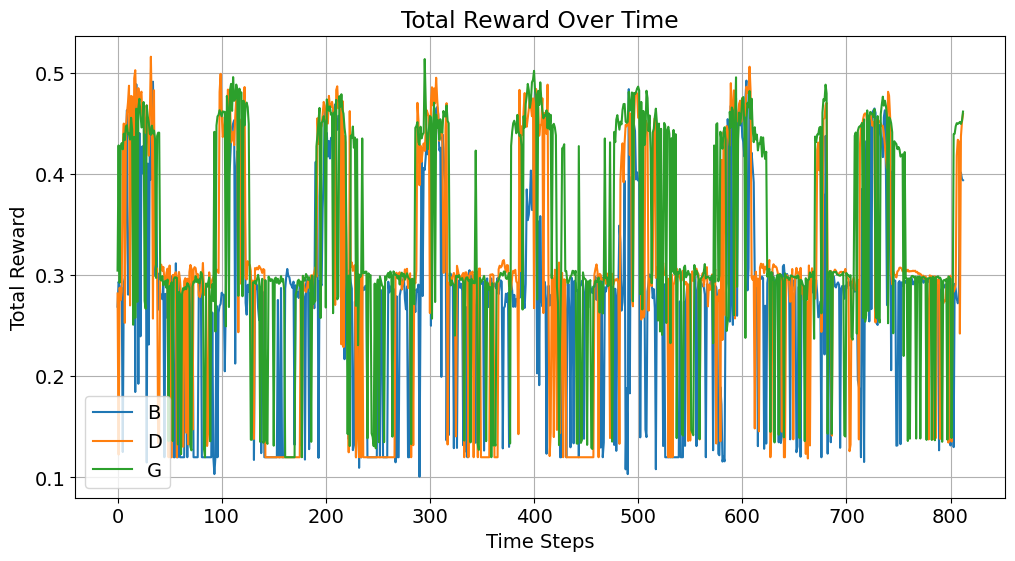

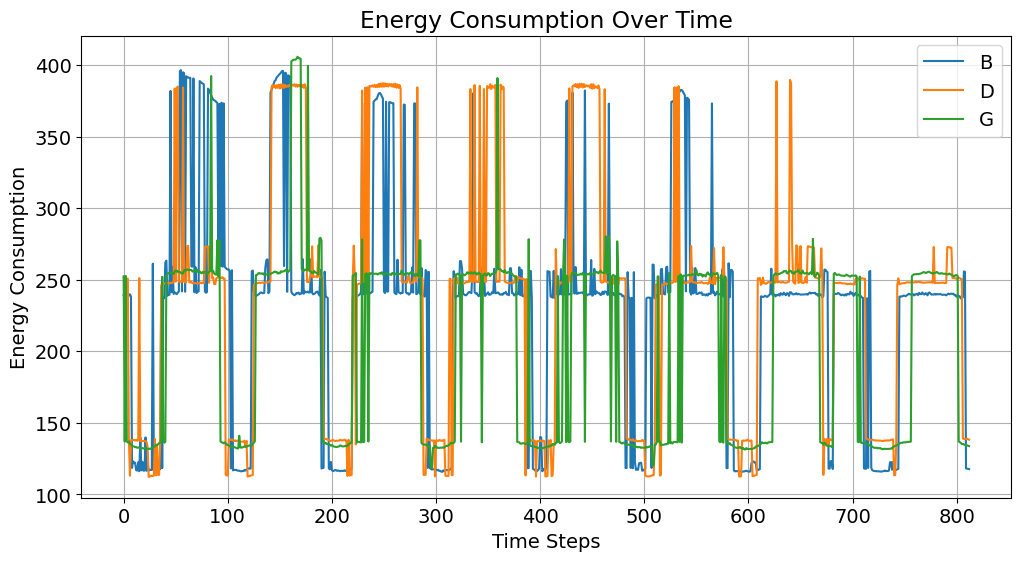

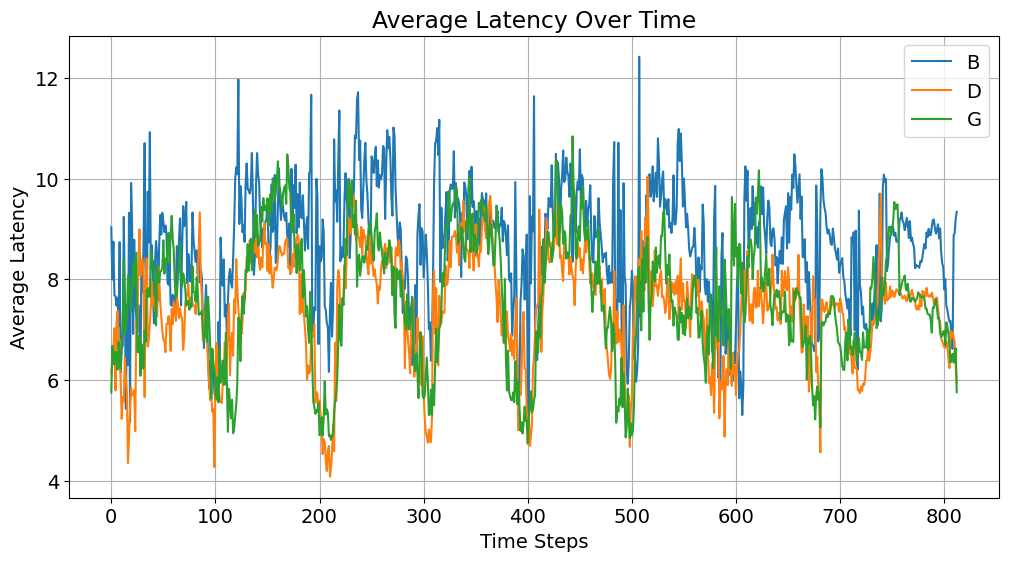

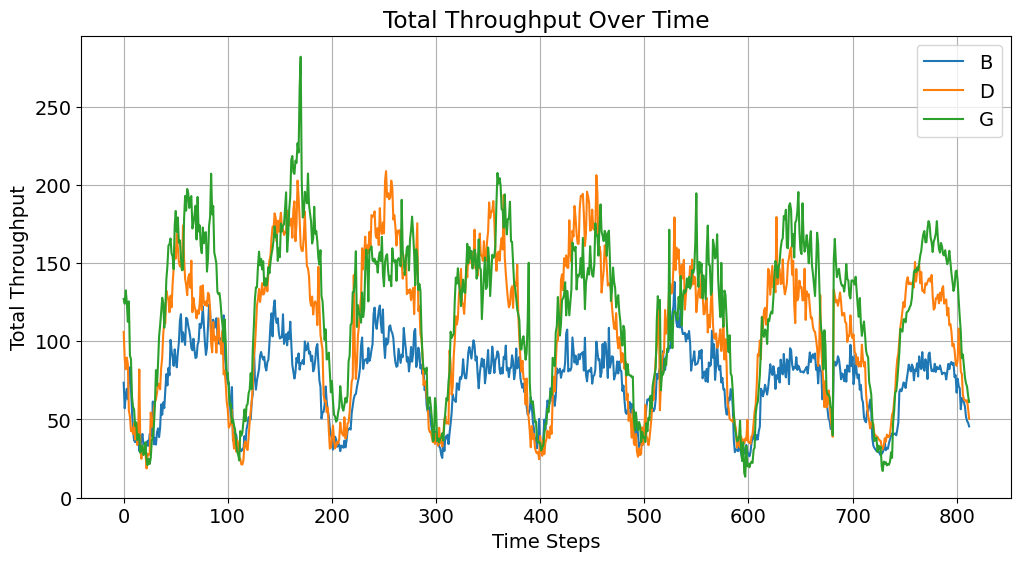

In [13]:
# Plotting
plot_metric(rewards_history, 'Total Reward', env.cell_sites)
plot_metric(energy_history, 'Energy Consumption', env.cell_sites)
plot_metric(latency_history, 'Average Latency', env.cell_sites)
plot_metric(throughput_history, 'Total Throughput', env.cell_sites)	 


/tmp/ipykernel_1476070/2888562049.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'BBU{i+1}' for i in range(3)], y=bbu_sleep_counts_site, palette='viridis')


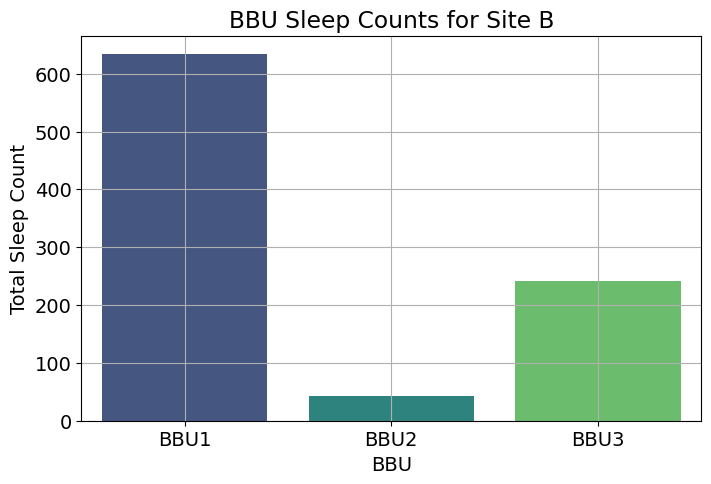

/tmp/ipykernel_1476070/2888562049.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'BBU{i+1}' for i in range(3)], y=bbu_sleep_counts_site, palette='viridis')


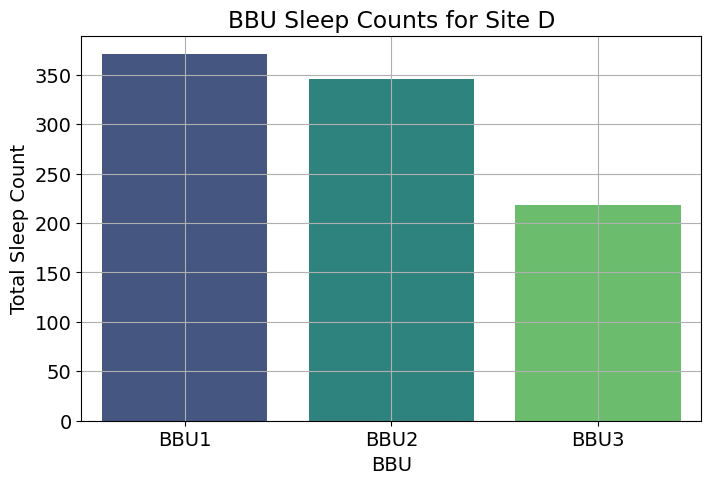

/tmp/ipykernel_1476070/2888562049.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'BBU{i+1}' for i in range(3)], y=bbu_sleep_counts_site, palette='viridis')


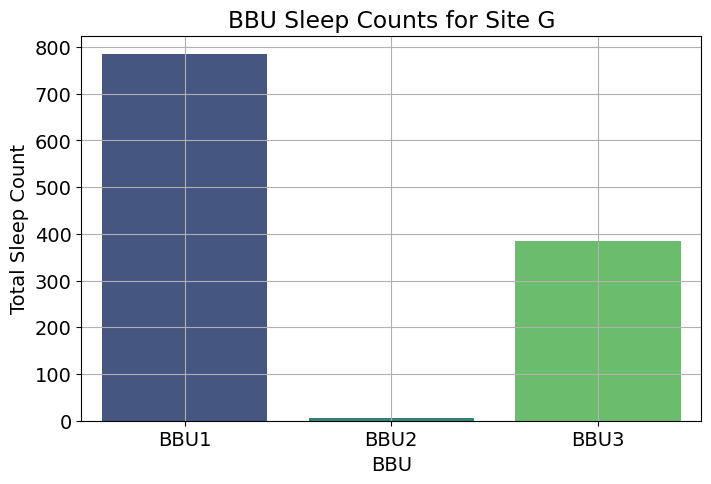

In [14]:
# Plot BBU Sleep Counts
for site in env.cell_sites:
    plt.rcParams.update({'font.size': 14})  # Set global font size to 14
    plt.figure(figsize=(8, 5))
    bbu_sleep_counts_site = bbu_sleep_counts[site]
    sns.barplot(x=[f'BBU{i+1}' for i in range(3)], y=bbu_sleep_counts_site, palette='viridis')
    plt.grid(True)
    plt.xlabel('BBU')
    plt.ylabel('Total Sleep Count')
    plt.title(f'BBU Sleep Counts for Site {site}')
    plt.show()


INFO:__main__:Site B - Energy Savings: 253.40, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 68.10, Normalized: 0.25
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.42
INFO:__main__:Site D - Energy Savings: 241.41, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -9.54, Normalized: -0.04
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.00
INFO:__main__:Site D - Total Reward: 0.26
INFO:__main__:Site G - Energy Savings: 250.91, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: 6.42, Normalized: 0.02
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.46


Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0]
Site D: Cannot sleep BBU 2; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 0]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0]
Site D: Cannot sleep BBU 2; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 0]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [2]
Site D: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site D: BBUs chosen to sleep: [1, 0]
Site G: Cann

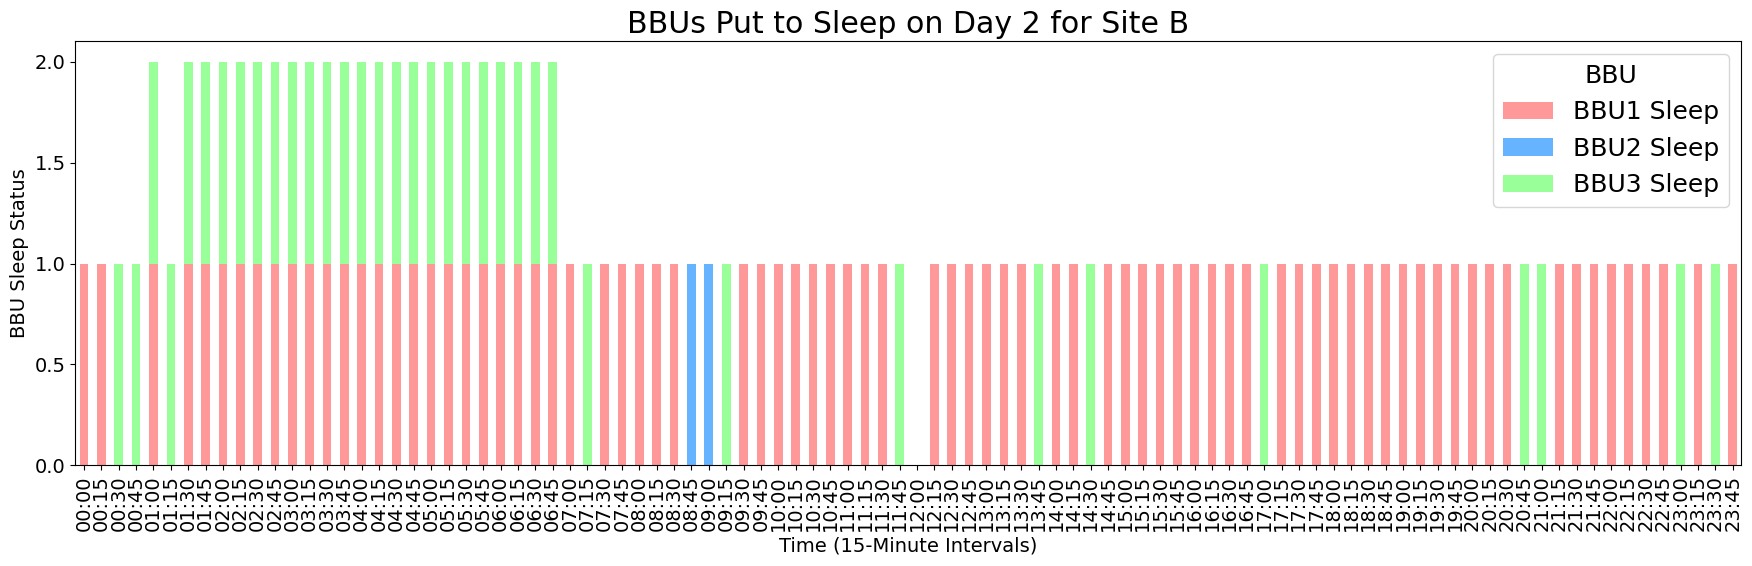

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

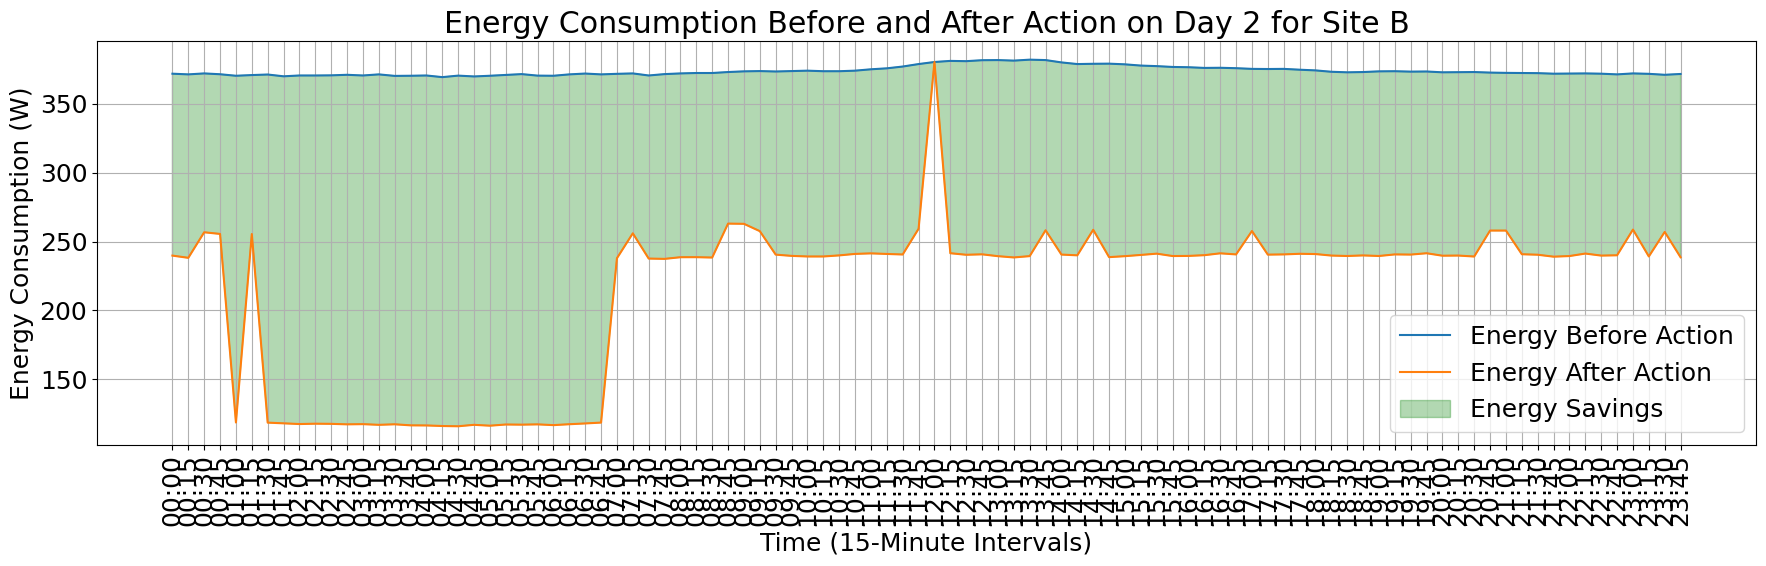

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


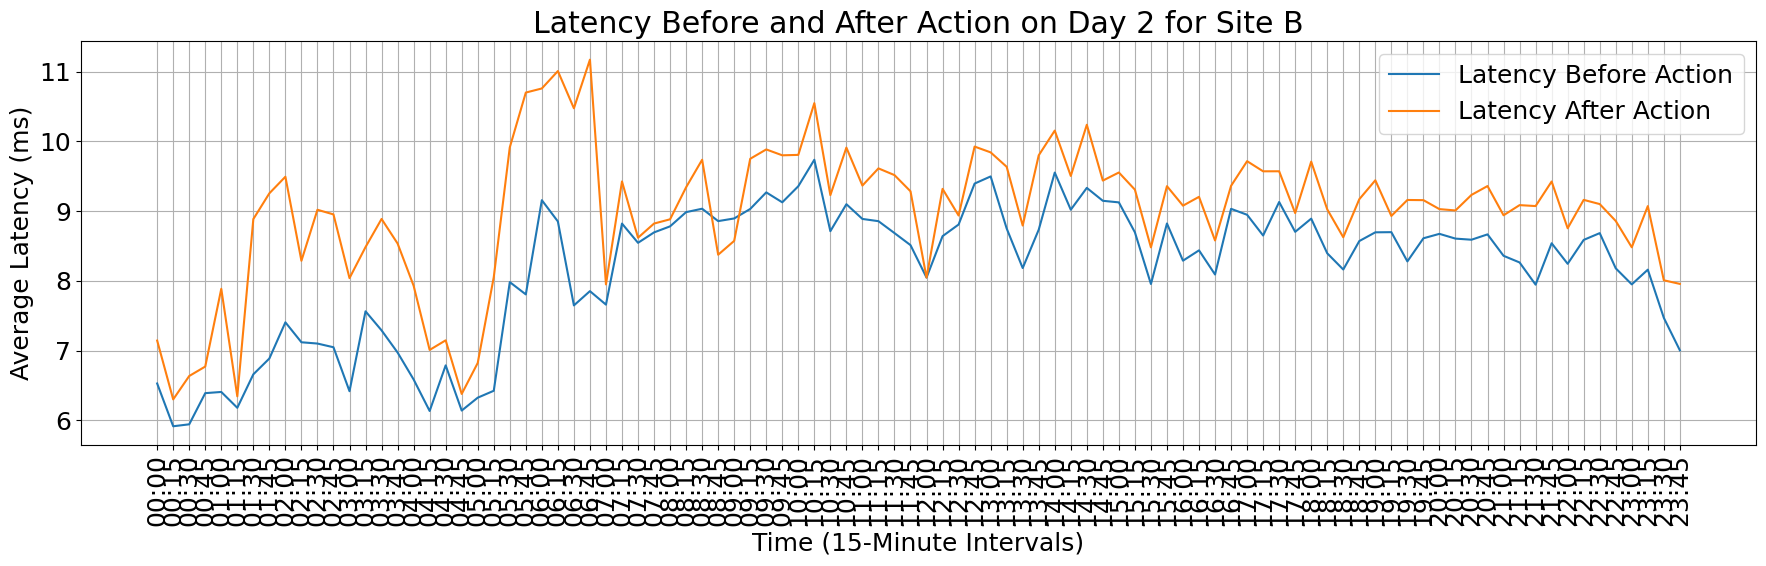

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


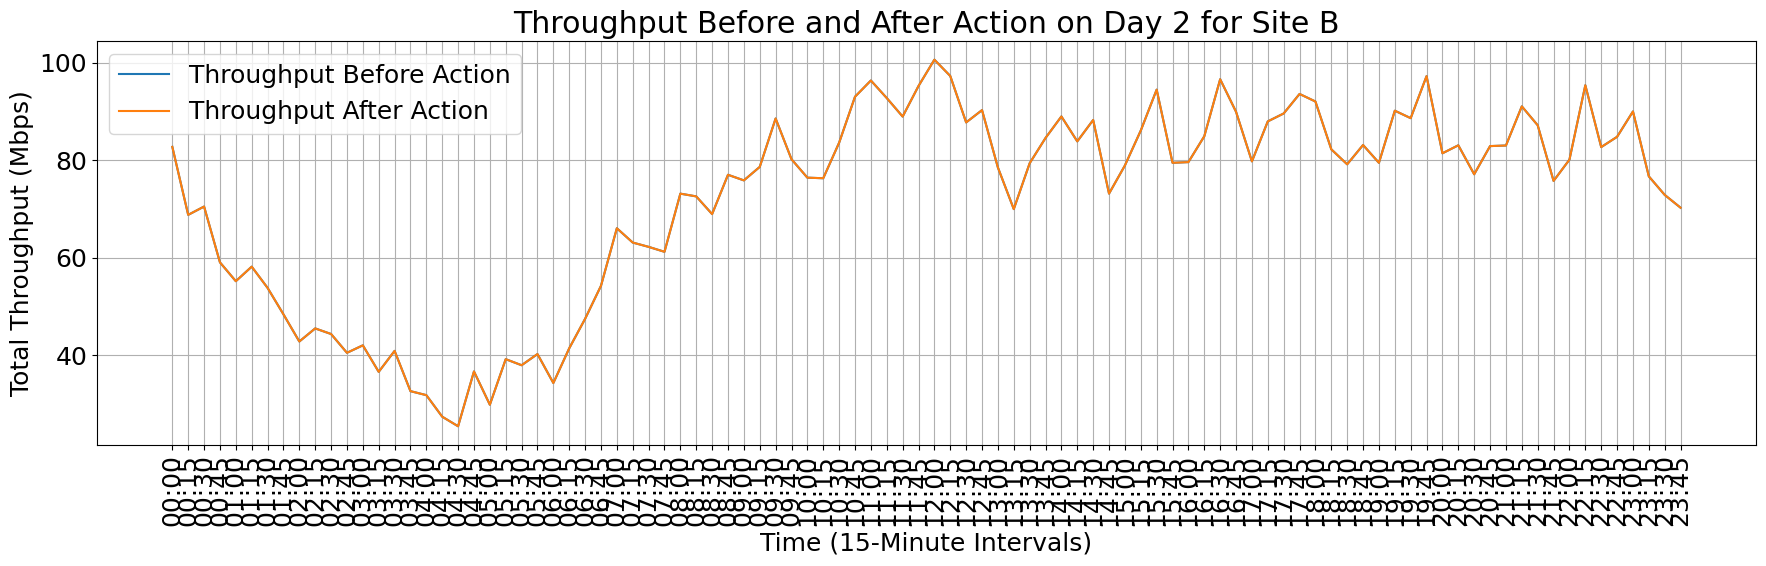


Detailed Metrics for Site B on Day 2:
     Time  Energy_Before  Energy_After  Energy_Saving  Latency_Before  \
0   00:00          372.0    239.794178     132.205822        6.527700   
1   00:15          371.5    238.174603     133.325397        5.914131   
2   00:30          372.2    256.742438     115.457562        5.942120   
3   00:45          371.6    255.544459     116.055541        6.389149   
4   01:00          370.5    118.520810     251.979190        6.406264   
..    ...            ...           ...            ...             ...   
91  22:45          371.5    240.025876     131.474124        8.179168   
92  23:00          372.2    258.699059     113.500941        7.949048   
93  23:15          371.9    239.172140     132.727860        8.159994   
94  23:30          371.2    256.988483     114.211517        7.468714   
95  23:45          371.8    238.548080     133.251920        7.003217   

    Latency_After  Throughput_Before  Throughput_After  
0        7.143170          

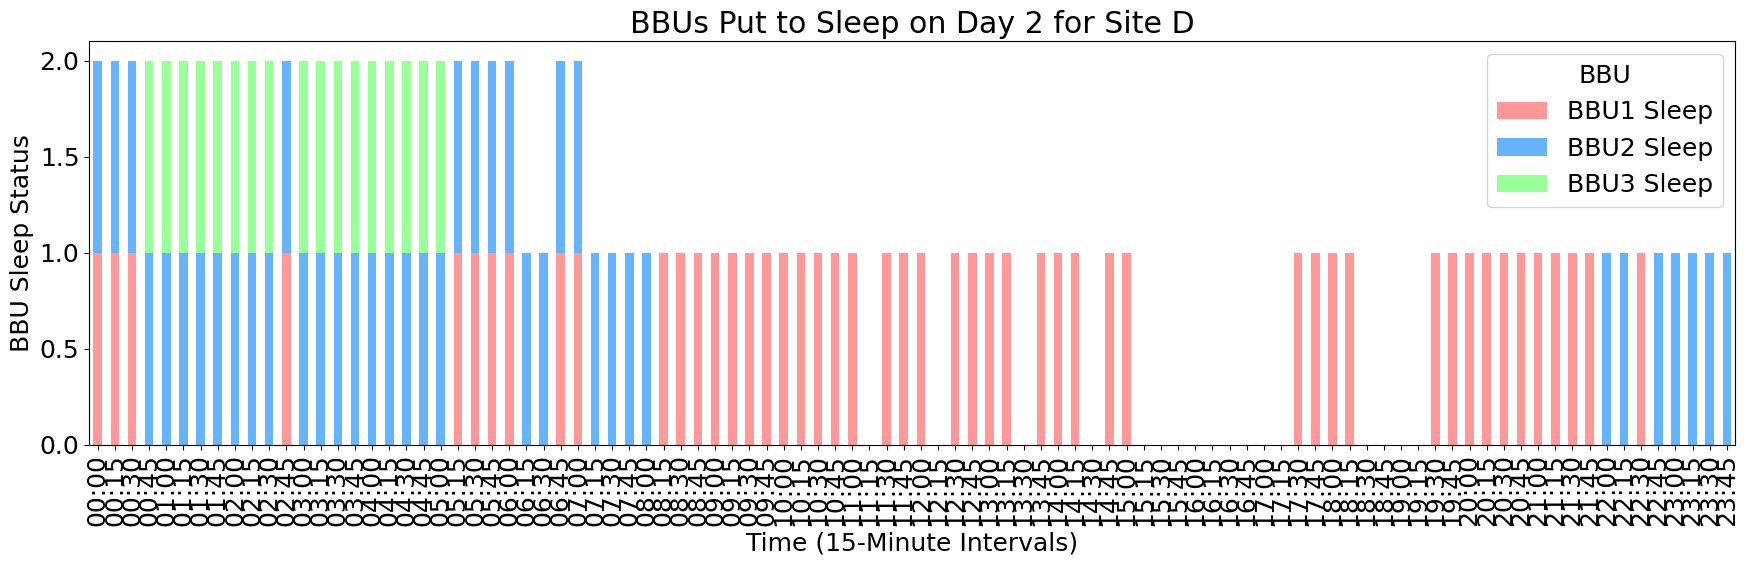

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

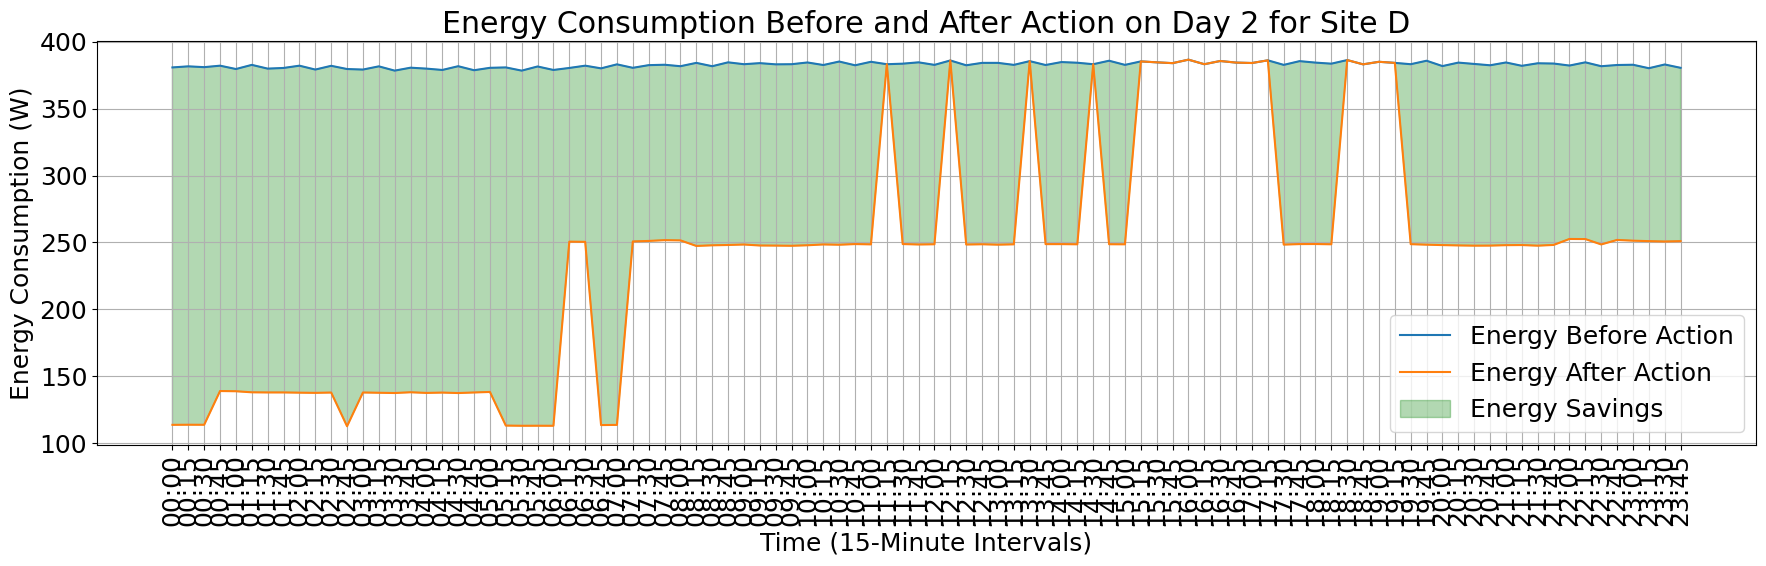

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


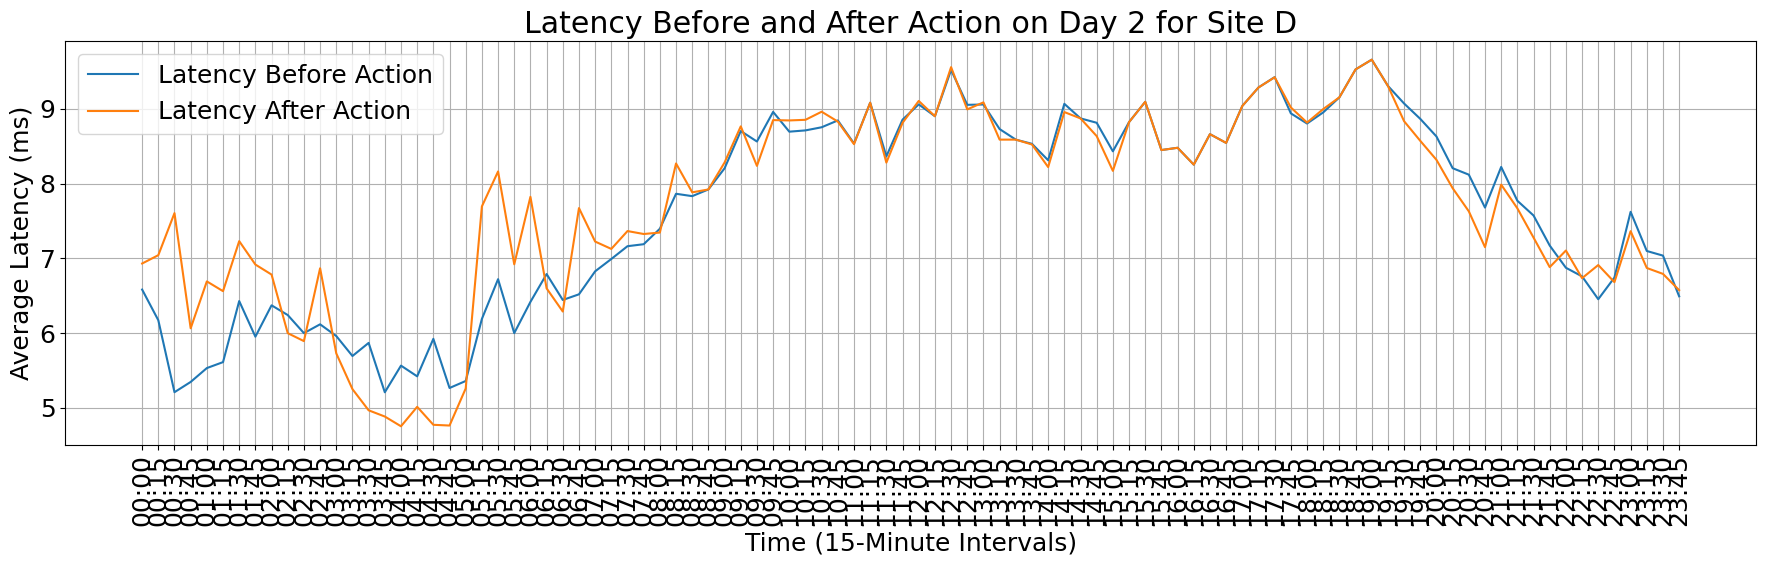

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


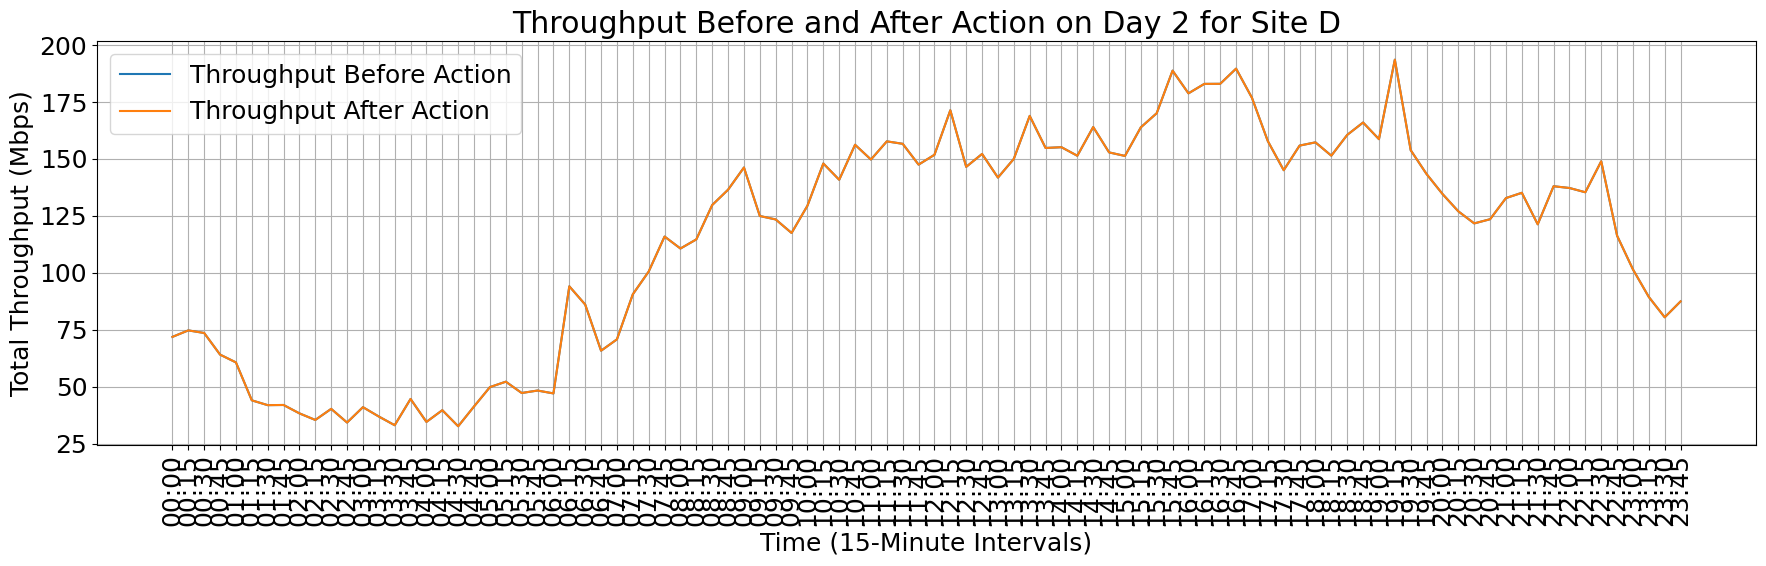


Detailed Metrics for Site D on Day 2:
     Time  Energy_Before  Energy_After  Energy_Saving  Latency_Before  \
0   00:00          380.8    113.611622     267.188378        6.584103   
1   00:15          381.6    113.691901     267.908099        6.173782   
2   00:30          381.0    113.659705     267.340295        5.211032   
3   00:45          382.1    138.892693     243.207307        5.348206   
4   01:00          379.6    138.728842     240.871158        5.533750   
..    ...            ...           ...            ...             ...   
91  22:45          382.6    251.843390     130.756610        6.744981   
92  23:00          382.8    251.277906     131.522094        7.624070   
93  23:15          380.2    250.937621     129.262379        7.100104   
94  23:30          383.0    250.662895     132.337105        7.038203   
95  23:45          380.5    250.929487     129.570513        6.493867   

    Latency_After  Throughput_Before  Throughput_After  
0        6.932607          

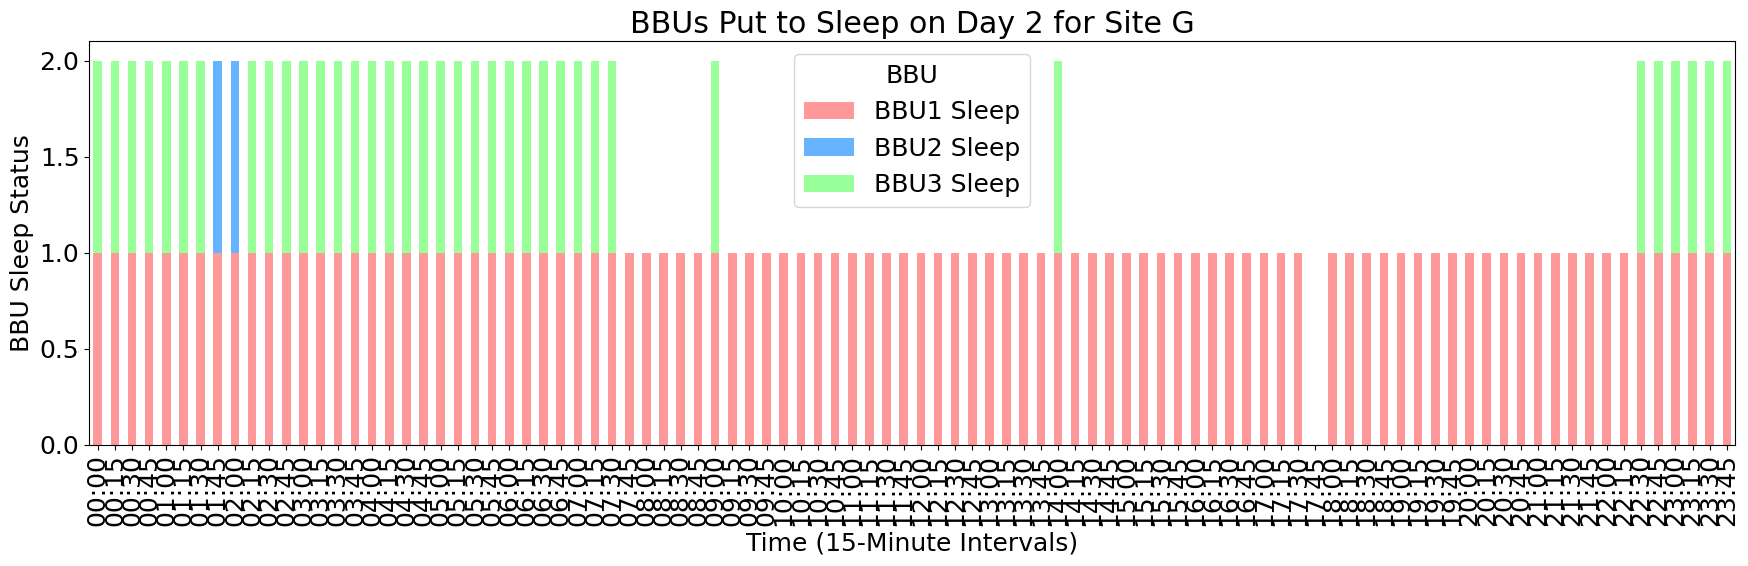

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

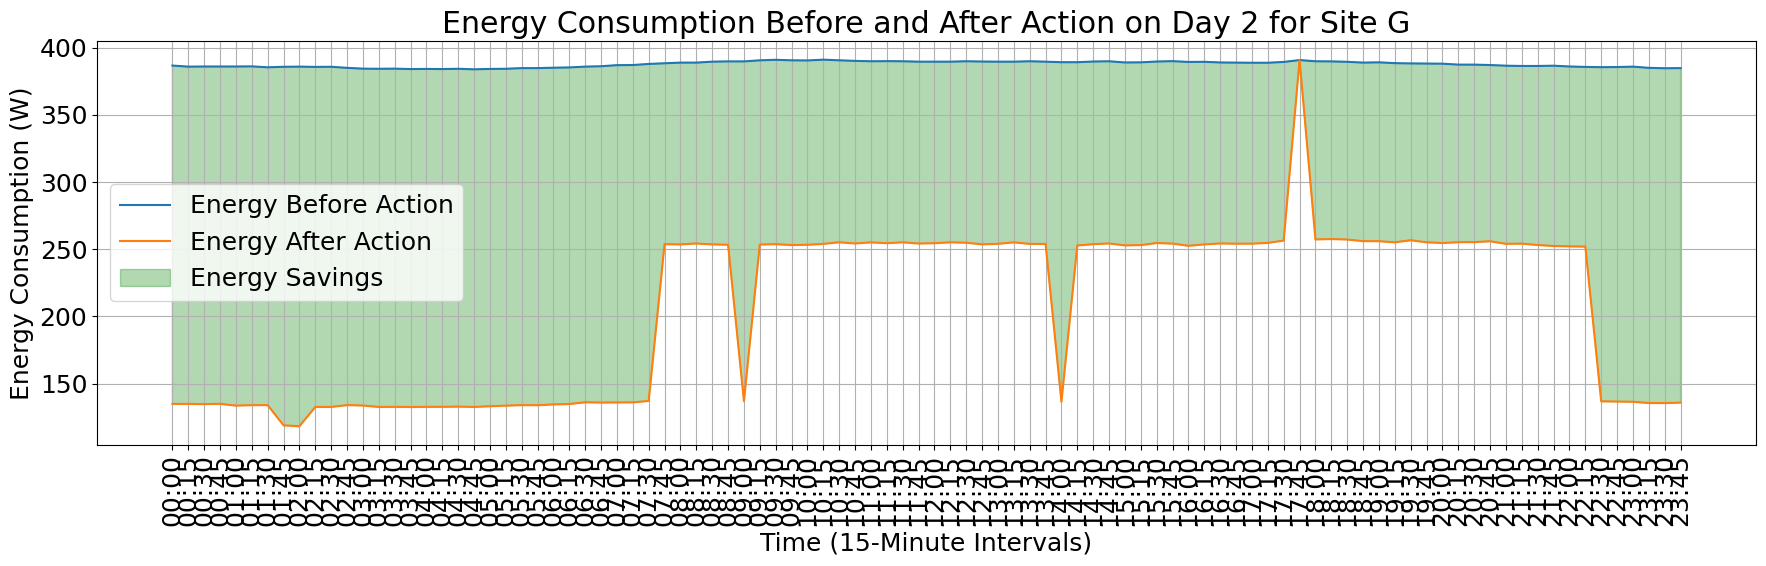

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


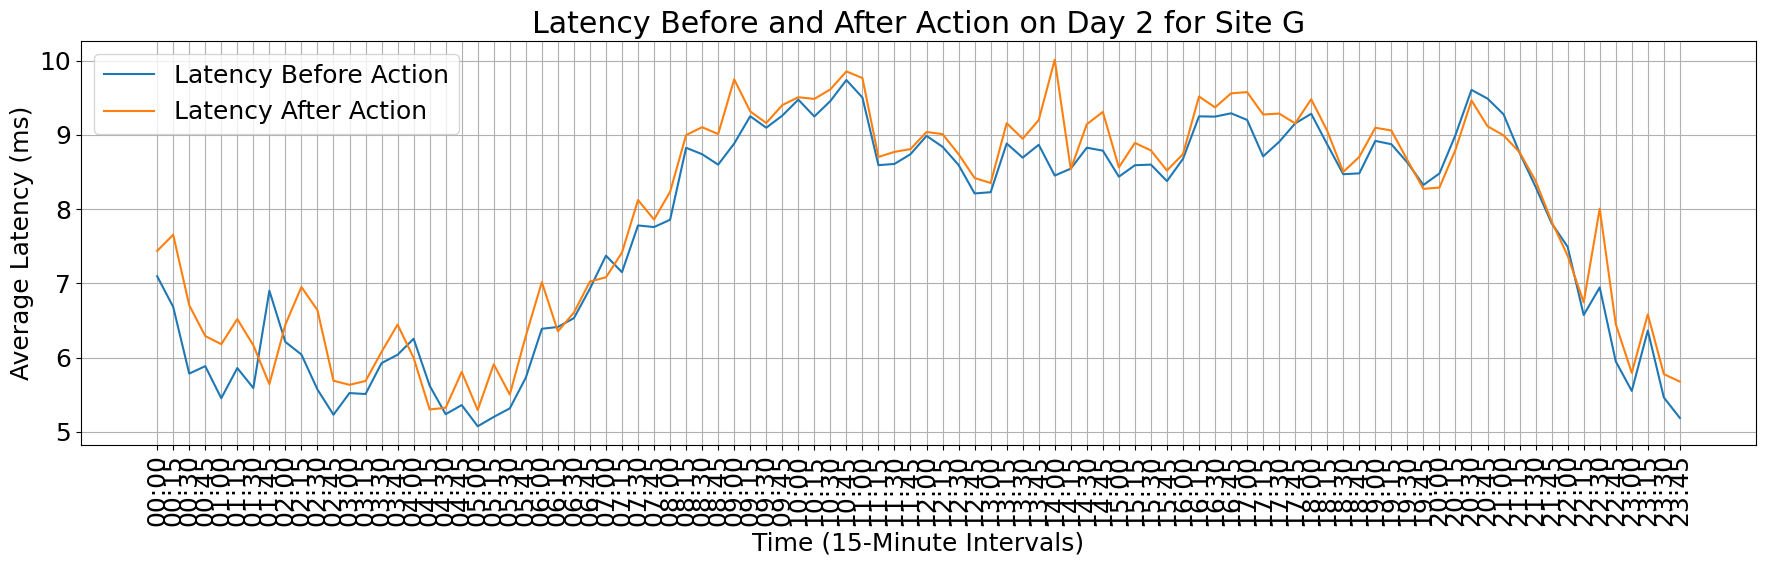

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


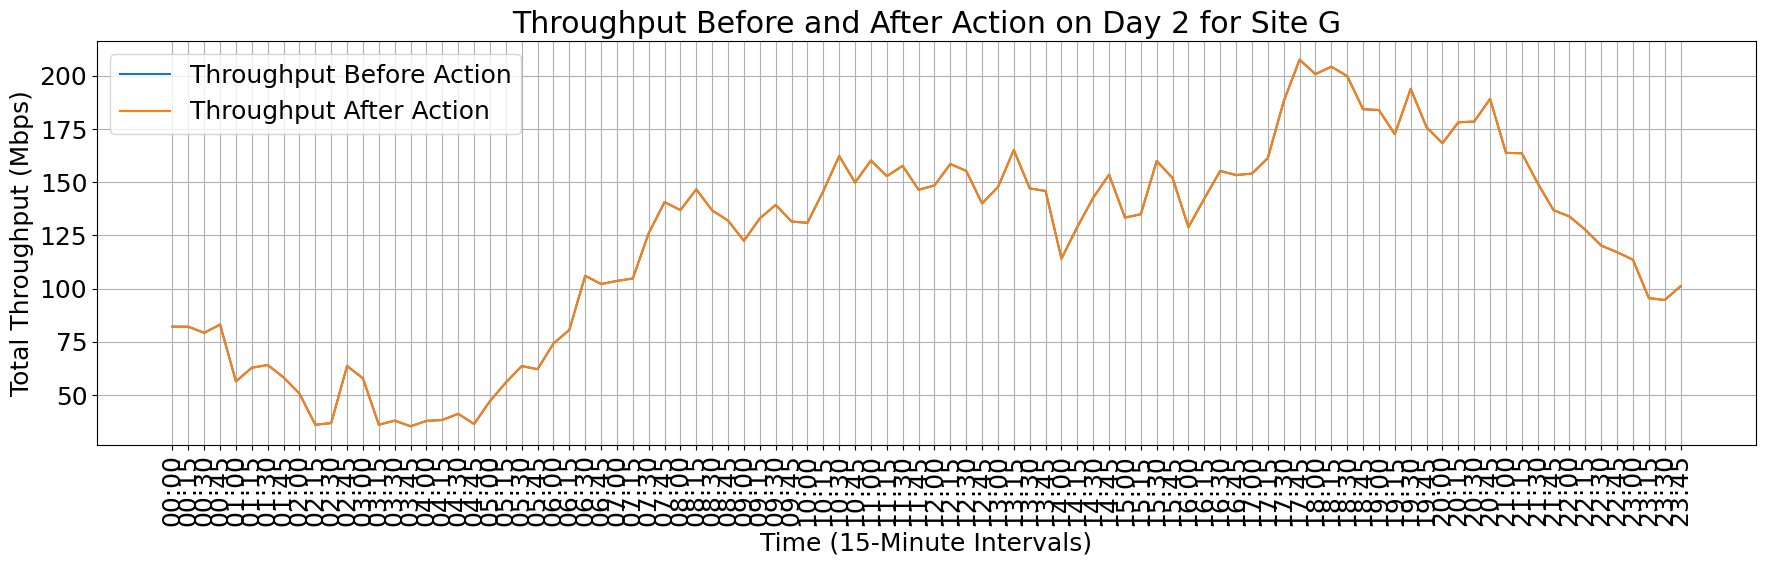


Detailed Metrics for Site G on Day 2:
     Time  Energy_Before  Energy_After  Energy_Saving  Latency_Before  \
0   00:00          386.8    134.803756     251.996244        7.095759   
1   00:15          386.0    134.802261     251.197739        6.682031   
2   00:30          386.1    134.658848     251.441152        5.783356   
3   00:45          386.1    134.852939     251.247061        5.883253   
4   01:00          386.1    133.522403     252.577597        5.450712   
..    ...            ...           ...            ...             ...   
91  22:45          385.7    136.547043     249.152957        5.947889   
92  23:00          386.0    136.371339     249.628661        5.549290   
93  23:15          385.1    135.472737     249.627263        6.362921   
94  23:30          384.8    135.427042     249.372958        5.461037   
95  23:45          384.9    135.751292     249.148708        5.185199   

    Latency_After  Throughput_Before  Throughput_After  
0        7.436973          

In [15]:
# Perform detailed evaluation on a specific day of the week
day_of_week = 2  # For example, Wednesday (0=Monday, 6=Sunday)
detailed_evaluation(env, day_of_week)

In [1]:
# Perform detailed evaluation summary
day_of_week = 0
detailed_evaluation_summary(env, day_of_week)

NameError: name 'detailed_evaluation_summary' is not defined

In [31]:
print("Date range in the data:", states['Datetime'].min(), "to", states['Datetime'].max())

Date range in the data: 2024-06-09 00:00:00 to 2024-06-16 02:15:00


# **Step 9: Thesis plot**

In [17]:
# Perform detailed evaluation summary

weekly_detailed_evaluation_summary(env)

INFO:__main__:Site B - Energy Savings: 114.21, Normalized: 0.31
INFO:__main__:Site B - Latency Increase: 1.10, Normalized: 0.00
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.16
INFO:__main__:Site B - Total Reward: 0.28
INFO:__main__:Site D - Energy Savings: 266.43, Normalized: 0.70
INFO:__main__:Site D - Latency Increase: 30.66, Normalized: 0.10
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.46
INFO:__main__:Site G - Energy Savings: 252.21, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: 9.24, Normalized: 0.02
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.46
INFO:__main__:Site B - Energy Savings: 253.98, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 56.77, Normalized: 0.21
INF

Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: []
Site D: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site D: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site D: BBUs chosen to sleep: [1]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [2, 0]
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [2]
Site D: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site D: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site D: BBUs chosen to sleep: [1]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not

INFO:__main__:Site B - Energy Savings: 253.40, Normalized: 0.68
INFO:__main__:Site B - Latency Increase: 68.10, Normalized: 0.25
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.20
INFO:__main__:Site B - Total Reward: 0.42
INFO:__main__:Site D - Energy Savings: 241.41, Normalized: 0.64
INFO:__main__:Site D - Latency Increase: -9.54, Normalized: -0.04
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.00
INFO:__main__:Site D - Total Reward: 0.26
INFO:__main__:Site G - Energy Savings: 250.91, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: 6.42, Normalized: 0.02
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.46
INFO:__main__:Site B - Energy Savings: 230.62, Normalized: 0.62
INFO:__main__:Site B - Latency Increase: -8.71, Normalized: -0.05


Site B: Cannot sleep BBU 1; at least one BBU must remain active.
Site B: BBUs chosen to sleep: [2, 0]
Site D: Cannot sleep BBU 0; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 2]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [2]
Site D: Cannot sleep BBU 0; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 2]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 1; at least one BBU must remain active.
Site B: BBUs chosen to sleep: [2, 0]
Site D: Cannot sleep BBU 0; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 2]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU

INFO:__main__:Site D - Overload Prevention Bonus: 0.20
INFO:__main__:Site D - Total Reward: 0.46
INFO:__main__:Site G - Energy Savings: 251.56, Normalized: 0.65
INFO:__main__:Site G - Latency Increase: -26.15, Normalized: -0.12
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.20
INFO:__main__:Site G - Total Reward: 0.49
INFO:__main__:Site B - Energy Savings: 132.10, Normalized: 0.35
INFO:__main__:Site B - Latency Increase: 52.70, Normalized: 0.08
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.16
INFO:__main__:Site B - Total Reward: 0.29
INFO:__main__:Site D - Energy Savings: 136.19, Normalized: 0.36
INFO:__main__:Site D - Latency Increase: 11.70, Normalized: 0.02
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.16
INFO:__main__:Site D - Total Reward: 0.30
INFO:__main__:Site G - Energy S

Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [2, 0]
Site B: Cannot sleep BBU 1; at least one BBU must remain active.
Site B: BBUs chosen to sleep: [0, 2]
Site D: Cannot sleep BBU 2; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 0]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [2, 0]
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0]
Site D: Cannot sleep BBU 2; at least one BBU must remain active.
Site D: BBUs chosen to sleep: [1, 0]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [2, 0]
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0]
Site D: Cannot sleep BBU 2; at least one BBU must remain active.
Sit

INFO:__main__:Site B - Energy Savings: 134.23, Normalized: 0.36
INFO:__main__:Site B - Latency Increase: 31.00, Normalized: 0.06
INFO:__main__:Site B - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site B - Overload Prevention Bonus: 0.00
INFO:__main__:Site B - Total Reward: 0.13
INFO:__main__:Site D - Energy Savings: 133.77, Normalized: 0.35
INFO:__main__:Site D - Latency Increase: -0.42, Normalized: -0.00
INFO:__main__:Site D - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site D - Overload Prevention Bonus: 0.16
INFO:__main__:Site D - Total Reward: 0.30
INFO:__main__:Site G - Energy Savings: 139.19, Normalized: 0.35
INFO:__main__:Site G - Latency Increase: 28.19, Normalized: 0.03
INFO:__main__:Site G - Overload Penalty: 0.00, Normalized: 0.00
INFO:__main__:Site G - Overload Prevention Bonus: 0.16
INFO:__main__:Site G - Total Reward: 0.30
INFO:__main__:Site B - Energy Savings: 133.46, Normalized: 0.36
INFO:__main__:Site B - Latency Increase: 97.90, Normalized: 0.17


Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0]
Site D: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site D: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site D: BBUs chosen to sleep: [1]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [2, 0]
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: [0]
Site D: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site D: Cannot sleep BBU 0; not enough capacity in other BBUs.
Site D: BBUs chosen to sleep: [1]
Site G: Cannot sleep BBU 1; at least one BBU must remain active.
Site G: BBUs chosen to sleep: [0, 2]
Site B: Cannot sleep BBU 2; not enough capacity in other BBUs.
Site B: Cannot sleep BBU 1; not enough capacity in other BBUs.
Site B: BBUs chosen to sleep: 

,Site,Day_of_Week,Avg_Energy_Before,Avg_Energy_After,Avg_Energy_Saving,Avg_Latency_Before,Avg_Latency_After,Avg_Throughput_Before,Avg_Throughput_After
0,B,0,379.355208,246.200959,133.154249,8.059593,8.890755,80.405323,80.405323
1,D,0,383.308333,264.231770,119.076564,7.621554,7.638145,118.505927,118.505927
2,G,0,394.338542,232.578142,161.760400,7.882683,8.007386,138.153479,138.153479
3,B,1,372.950000,240.148495,132.801505,8.493433,9.261941,78.695615,78.695615
4,D,1,383.231250,264.465884,118.765366,7.470894,7.504648,121.235656,121.235656
5,G,1,392.967708,207.678692,185.289016,7.303154,7.530537,124.846417,124.846417
6,B,2,373.906250,214.784393,159.121857,8.169227,8.988098,71.929208,71.929208
7,D,2,382.717708,239.211509,143.506200,7.648567,7.730367,115.695365,115.695365
8,G,2,387.759375,206.746173,181.013202,7.705467,7.943040,122.887406,122.887406
9,B,3,374.985417,229.182787,145.802629,7.924739,8.833096,74.889156,74.889156
